# ComplexFastICA Function


In [1]:
from __future__ import division
import pdb, os, time, warnings
import numpy as np
from math import log
from numpy.linalg import *
from numpy.random import rand

"""
Author: Alex Bujan
Adapted from: Ella Bingham, 1999

Original article citation:
Ella Bingham and Aapo Hyvaerinen, "A fast fixed-point algorithm for
independent component analysis of complex valued signals",
International Journal of Neural Systems, Vol. 10, No. 1 (February, 2000) 1-8

Original code url:
http://users.ics.aalto.fi/ella/publications/cfastica_public.m

Date: 12/11/2015

TODO: include arbitrary contrast functions
"""

def abs_sqr(W, X):
    """Computes the squared absolute value of the dot product of W^H (Hermitian transpose) and X."""
    return abs(W.conj().T.dot(X))**2

def complex_FastICA(X, epsilon=0.1, algorithm='parallel',
                    max_iter=100, tol=1e-4, whiten=True,
                    w_init=None, n_components=None):
    """Performs Fast Independent Component Analysis (ICA) for complex-valued signals.

    Parameters:
    ----------
    X : ndarray, shape (n_features, n_samples)
        Input signal X = A S, where A is the mixing matrix and S represents latent sources.

    epsilon : float, optional (regularization parameter to prevent division by zero)
        A small constant used in the contrast function approximation for neg-entropy.

    algorithm : {'parallel', 'deflation'}, optional
        Determines whether to apply the parallel or deflationary FastICA algorithm.

    w_init : ndarray, optional
        Initial un-mixing matrix. If None, it's randomly initialized.

    tol : float, optional
        Convergence threshold for the un-mixing matrix.

    max_iter : int, optional
        Maximum number of iterations before stopping.

    whiten : bool, optional
        If True, performs initial whitening (preprocessing step).

    n_components : int, optional
        Number of independent components to extract.

    Returns:
    -------
    W : ndarray, shape (n_components, n_components)
        Estimated un-mixing matrix.

    K : ndarray, shape (n_components, n_features)
        Whitening matrix if `whiten` is True, otherwise None.

    EG : ndarray, shape (n_components, max_iter)
        Expectation of the contrast function E[G(|W'*X|^2)].

    S : ndarray, shape (n_samples, n_components)
        Extracted independent source signals.
    """

    n, m = X.shape  # n = number of features, m = number of samples

    # Adjust the number of components if specified
    if n_components is not None:
        n = n_components

    # Whitening step (decorrelating and normalizing variance)
    if whiten:
        X -= X.mean(1, keepdims=True)  # Centering data
        Ux, Sx = eig(np.cov(X))  # Eigen decomposition of covariance matrix
        K = np.sqrt(inv(np.diag(Ux))).dot(Sx.conj().T)[:n]  # Compute whitening matrix
        X = K.dot(X)  # Apply whitening transformation
        del Ux, Sx
    else:
        K = None  # No whitening applied


    # Initialize the contrast function expectation array with NaNs
    EG = np.ones((n, max_iter)) * np.nan

    # Deflation-based ICA (one component at a time)
    if algorithm == 'deflation':
        W = np.zeros((n, n), dtype=np.complex64)  # Initialize un-mixing matrix

        for k in range(n):  # Extract one independent component at a time
            if w_init is not None:
                w = w_init[:, k]  # Use provided initialization
            else:
                # Randomly initialize weights with complex values
                w = np.random.normal(size=(n, 1)) + 1j * np.random.normal(size=(n, 1))

            w /= norm(w)  # Normalize weight vector

            n_iter = 0
            for i in range(max_iter):
                wold = np.copy(w)  # Store previous iteration's weights

                # Compute derivative of the contrast function
                g = 1 / (epsilon + abs_sqr(w, X))
                dg = -1 / (epsilon + abs_sqr(w, X))**2  # Second derivative

                # Update rule for FastICA (Newton iteration)
                w = (X * (w.conj().T.dot(X)).conj() * g).mean(1).reshape((n, 1)) - \
                    (g + abs_sqr(w, X) * dg).mean() * w

                del g, dg  # Free memory

                w /= norm(w)  # Normalize updated weights

                # Decorrelate with previously found components
                w -= W.dot(W.conj().T).dot(w) #remove projection on previous components
                w /= norm(w)  # Normalize again

                EG[k, n_iter] = (np.log(epsilon + abs_sqr(w, X))).mean()  # Compute contrast function expectation

                n_iter += 1
                lim = (abs(abs(wold) - abs(w))).sum()  # Check for convergence
                if lim < tol:
                    break  # Stop if convergence criterion is met

            if n_iter == max_iter and lim > tol:
                warnings.warn('FastICA did not converge. Consider increasing tolerance or max iterations.')

            W[:, k] = w.ravel()  # Store the learned component

    # Parallel FastICA (all components simultaneously)
    elif algorithm == 'parallel':
        if w_init is not None:
            W = w_init  # Use provided initialization
        else:
            # Randomly initialize weight matrix with complex values
            W = np.random.normal(size=(n, n)) + 1j * np.random.normal(size=(n, n))

        n_iter = 0
        C = np.cov(X)  # Cache covariance matrix of input data

        for i in range(max_iter):
            Wold = np.copy(W)  # Store previous iteration's weights

            for j in range(n):  # Update each component in parallel
                g = (1 / (epsilon + abs_sqr(W[:, j], X))).reshape((1, m))  # Compute g
                dg = -(1 / (epsilon + abs_sqr(W[:, j], X))**2).reshape((1, m))  # Compute derivative of g

                # Update weights using gradient ascent
                W[:, j] = (X * (W[:, j].conj().T.dot(X)).conj() * g).mean(1) - \
                          (g + abs_sqr(W[:, j], X) * dg).mean() * W[:, j]
                del g, dg  # Free memory

            # Perform symmetric decorrelation (whitening of W)
            Uw, Sw = eig(W.conj().T.dot(C.dot(W)))  # Eigen decomposition
            W = W.dot(Sw.dot(inv(np.sqrt(np.diag(Uw))).dot(Sw.conj().T)))  # Normalize
            del Uw, Sw  # Free memory

            EG[:, n_iter] = (np.log(epsilon + abs_sqr(W, X))).mean(1)  # Compute contrast function expectation

            n_iter += 1
            lim = (abs(abs(Wold) - abs(W))).sum()  # Check for convergence
            if lim < tol:
                break  # Stop if convergence criterion is met

        if n_iter == max_iter and lim > tol:
            warnings.warn('FastICA did not converge. Consider increasing tolerance or max iterations.')

    # Compute estimated sources
    S = W.conj().T.dot(X)

    return K, W, S, EG


Original Demo Code

(9, 9) (9, 9) (9, 50000) (9, 40)

SSE:0.0009

SIR:-16.0557


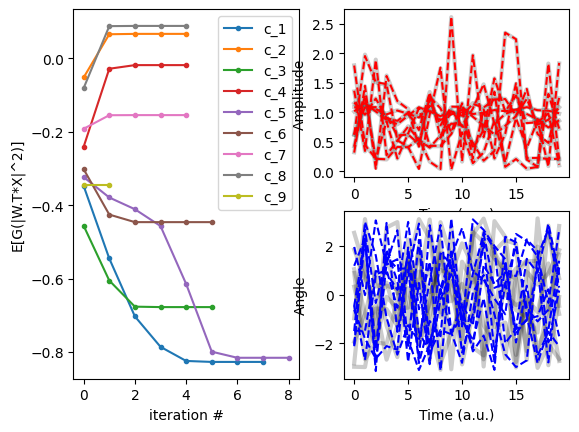

In [2]:
import pdb,os,time
import numpy as np
from math import log,log10

from fontTools.misc.py23 import xrange
from numpy.linalg import *
from numpy.random import rand
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
# import complex_FastICA as cica
#reload(cica)

plt.ion()


m = 50000
j = 0


# some parameters for the available distributions

bino1 = np.maximum(2, np.ceil(20*rand()))
bino2 = rand()
exp1 = np.ceil(10*rand())
gam1 = np.ceil(10*rand())
gam2 = gam1 + np.ceil(10*rand())
f1 = np.ceil(10*rand())
f2 = np.ceil(100*rand())
poiss1 = np.ceil(10*rand())
nbin1 = np.ceil(10*rand())
nbin2 = rand()
hyge1 = np.ceil(900*rand())
hyge2 = np.ceil(20*rand())
hyge3 = round(hyge1/np.maximum(2,np.ceil(5*rand())))
chi1 = np.ceil(20*rand())
beta1 = np.ceil(10*rand())
beta2 = beta1 + np.ceil(10*rand())
unif1 = np.ceil(2*rand())
unif2 = unif1 + np.ceil(2*rand())
gam3 = np.ceil(20*rand())
gam4 = gam3 + np.ceil(20*rand())
f3 = np.ceil(10*rand())
f4 = np.ceil(50*rand())
exp2 = np.ceil(20*rand())
rayl1 = 10
unid1 = np.ceil(100*rand())
norm1 = np.ceil(10*rand())
norm2 = np.ceil(10*rand())
logn1 = np.ceil(10*rand())
logn2 = np.ceil(10*rand())
geo1 = rand()
weib1 = np.ceil(10*rand())
weib2 = weib1 + np.ceil(10*rand())



r = np.random.binomial(bino1,bino2,size=(1,m))
r = np.vstack([r,np.random.gamma(gam1,gam2,size=(1,m))])
r = np.vstack([r,np.random.poisson(poiss1,size=(1,m))])
r = np.vstack([r,np.random.hypergeometric(hyge1,hyge2,hyge3,size=(1,m))])
r = np.vstack([r,np.random.beta(beta1,beta2,size=(1,m))])
r = np.vstack([r,np.random.exponential(exp1,size=(1,m))])
r = np.vstack([r,np.random.uniform(unid1,size=(1,m))])
r = np.vstack([r,np.random.normal(norm1,norm2,size=(1,m))])
r = np.vstack([r,np.random.geometric(geo1,size=(1,m))])


n = r.shape[0]
#np.random.seed(1234)
f = np.random.uniform(-2*np.pi,2*np.pi,size=(n,m))


S = r*(np.cos(f)+1j*np.sin(f))


# Standardize data
S = inv(np.diag(S.std(1))).dot(S)
#print(S)
# Mixing using complex mixing matrix A
A = rand(n,n)+1j*rand(n,n)
#print(A)
X = A.dot(S)
#print(type(X[0]))
alg = 'deflation'#'parallel'

K,W,Shat,EG = complex_FastICA(X,max_iter=40,algorithm=alg,n_components=n)
print(K.shape, W.shape, Shat.shape, EG.shape)
#print(EG)

#Compute the SSE
absKAHW  = np.abs((K.dot(A)).conj().T.dot(W))

#print('\nPermutation matrix: \n%s'%str(np.round(absKAHW)))

maximum = absKAHW.max(0)
SSE     = ((absKAHW**2).sum(0)-maximum**2+(1-maximum)**2).sum()
SIR     = 10*log10(((absKAHW*1./maximum).sum(0)-1).mean())

print("\nSSE:%.4f"%SSE)
print( "\nSIR:%.4f"%SIR)

span = 20
start=np.random.randint(m-span)


fig = plt.figure('fastICA_demo')
fig.clf()

ax1      = fig.add_subplot(121)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]),'.-',label='c_%i'%(j+1))
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('iteration #')
plt.legend(loc='best')

ax2  = fig.add_subplot(222)
ax2.plot(np.abs(S[:,start:start+span]).T,lw=3,alpha=.2,color='k')
ax2.plot(np.abs(Shat[:,start:start+span]).T,'--',color='r')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')

ax3  = fig.add_subplot(224)
ax3.plot(np.angle(S[:,start:start+span]).T,lw=3,alpha=.2,color='k')
ax3.plot(np.angle(Shat[:,start:start+span]).T,'--',color='b')
ax3.set_ylabel('Angle')
ax3.set_xlabel('Time (a.u.)')

plt.show()


# Implementation (Orignal Code Better Rep)


SSE: 0.0017

SIR: -15.4191


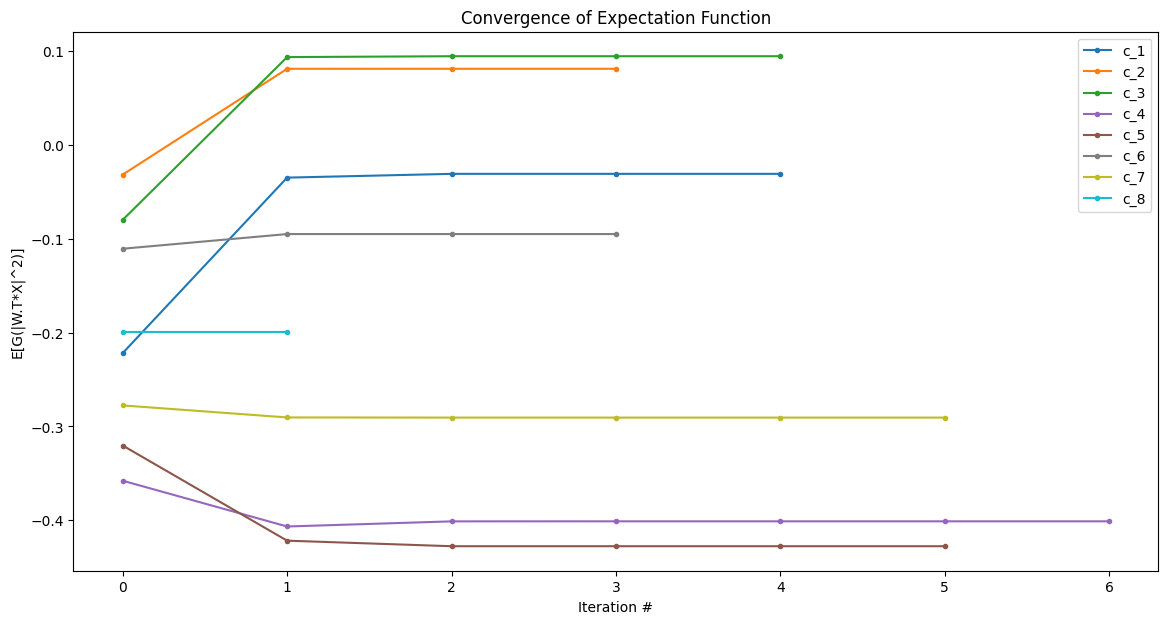

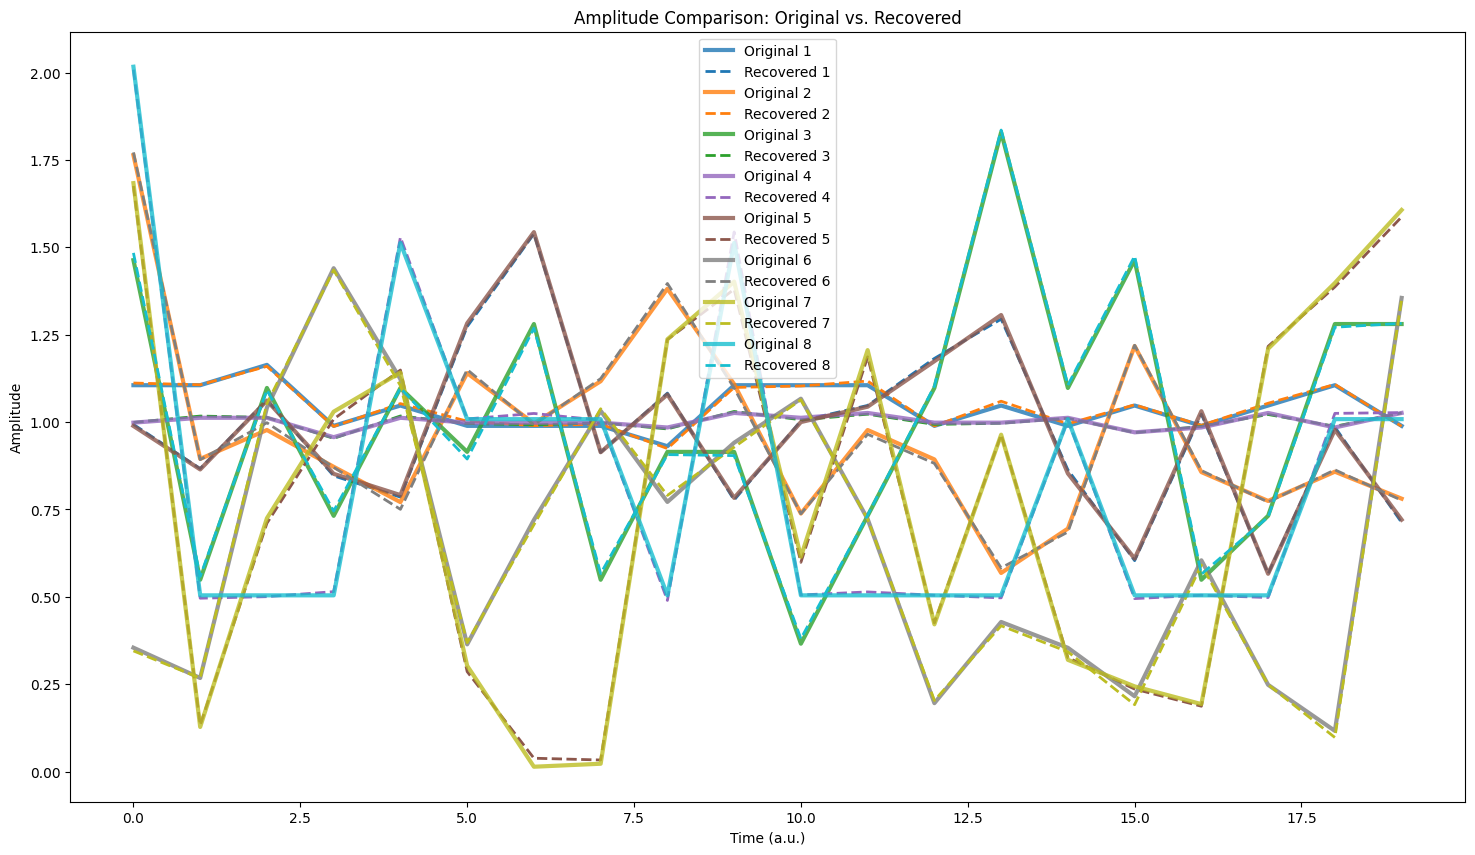

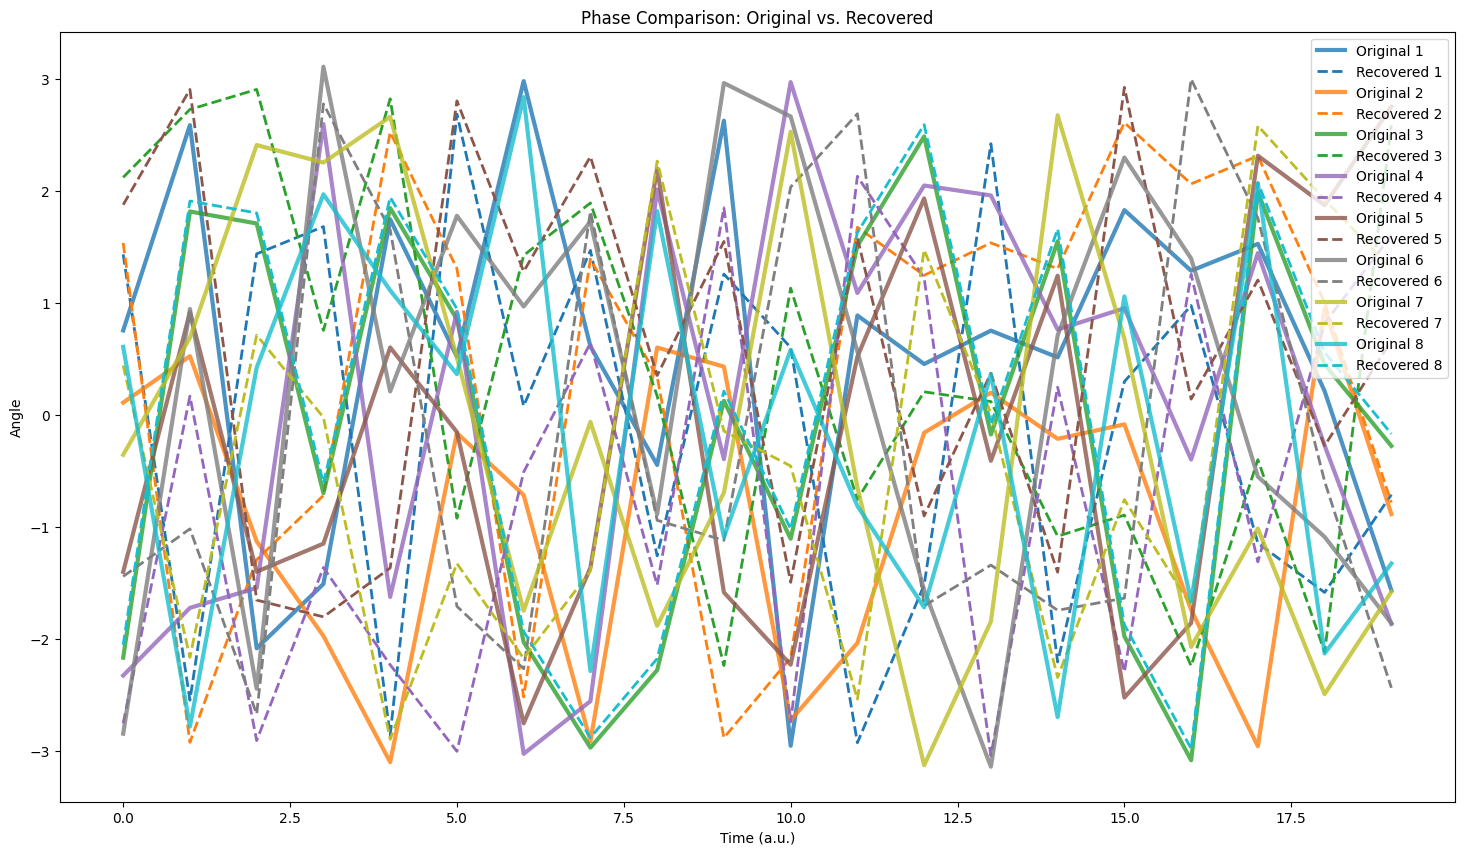

In [3]:
import pdb, os, time, warnings
import numpy as np
from math import log, log10
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.random import rand

plt.ion()

# Number of samples
m = 50000
j = 0

# Generate parameters for different distributions
bino1 = np.maximum(2, np.ceil(20 * rand()))
bino2 = rand()
exp1 = np.ceil(10 * rand())
gam1 = np.ceil(10 * rand())
gam2 = gam1 + np.ceil(10 * rand())
poiss1 = np.ceil(10 * rand())
hyge1 = np.ceil(900 * rand())
hyge2 = np.ceil(20 * rand())
hyge3 = round(hyge1 / np.maximum(2, np.ceil(5 * rand())))
beta1 = np.ceil(10 * rand())
beta2 = beta1 + np.ceil(10 * rand())
unid1 = np.ceil(100 * rand())
norm1 = np.ceil(10 * rand())
norm2 = np.ceil(10 * rand())
geo1 = rand()

# Generate independent components (random signals from different distributions)
r = np.random.binomial(bino1, bino2, size=(1, m))
r = np.vstack([r, np.random.gamma(gam1, gam2, size=(1, m))])
r = np.vstack([r, np.random.poisson(poiss1, size=(1, m))])
r = np.vstack([r, np.random.hypergeometric(hyge1, hyge2, hyge3, size=(1, m))])
r = np.vstack([r, np.random.beta(beta1, beta2, size=(1, m))])
r = np.vstack([r, np.random.uniform(unid1, size=(1, m))])
r = np.vstack([r, np.random.normal(norm1, norm2, size=(1, m))])
r = np.vstack([r, np.random.geometric(geo1, size=(1, m))])

# Number of independent components
n = r.shape[0]

# Generate random phase shifts for complex transformation
f = np.random.uniform(-2 * np.pi, 2 * np.pi, size=(n, m))

# Convert signals to complex by applying random phase shifts
S = r * (np.cos(f) + 1j * np.sin(f))

# Standardize signals
S = inv(np.diag(S.std(1))).dot(S)

# Mixing matrix (random complex mixing)
A = rand(n, n) + 1j * rand(n, n)
X = A.dot(S)  # Mixed signals

# Apply Complex FastICA
alg = 'deflation'  # or 'parallel'
K, W, Shat, EG = complex_FastICA(X, max_iter=40, algorithm=alg, n_components=n)

# Compute SSE and SIR
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * log10(((absKAHW * 1. / maximum).sum(0) - 1).mean())

print("\nSSE: %.4f" % SSE)
print("\nSIR: %.4f" % SIR)

# Select a small span of data for visualization
span = 20
start = np.random.randint(m - span)

# Generate distinct, easily differentiable colors for each component
colors = plt.cm.tab10(np.linspace(0, 1, n))  # Use `tab10` for more distinguishable colors

# **Convergence Plot**
fig1 = plt.figure(figsize=(14, 7))  # Increased figure size
ax1 = fig1.add_subplot(111)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', color=colors[j], label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
ax1.set_title('Convergence of Expectation Function')
plt.legend(loc='best')
plt.show()

# **Amplitude Plot (Original vs. Recovered)**
fig2 = plt.figure(figsize=(18, 10))  # Larger figure for multiple signals
ax2 = fig2.add_subplot(111)
for j in range(n):
    ax2.plot(np.abs(S[j, start:start+span]).T, lw=3, alpha=0.8, color=colors[j], label=f'Original {j+1}')
    ax2.plot(np.abs(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')
ax2.set_title('Amplitude Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()

# **Phase Angle Plot (Original vs. Recovered)**
fig3 = plt.figure(figsize=(18, 10))  # Separate figure for phase plot
ax3 = fig3.add_subplot(111)
for j in range(n):
    ax3.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.8, color=colors[j], label=f'Original {j+1}')
    ax3.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax3.set_ylabel('Angle')
ax3.set_xlabel('Time (a.u.)')
ax3.set_title('Phase Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()


# Demo (3 Components)


SSE: 0.0002

SIR: -20.4777


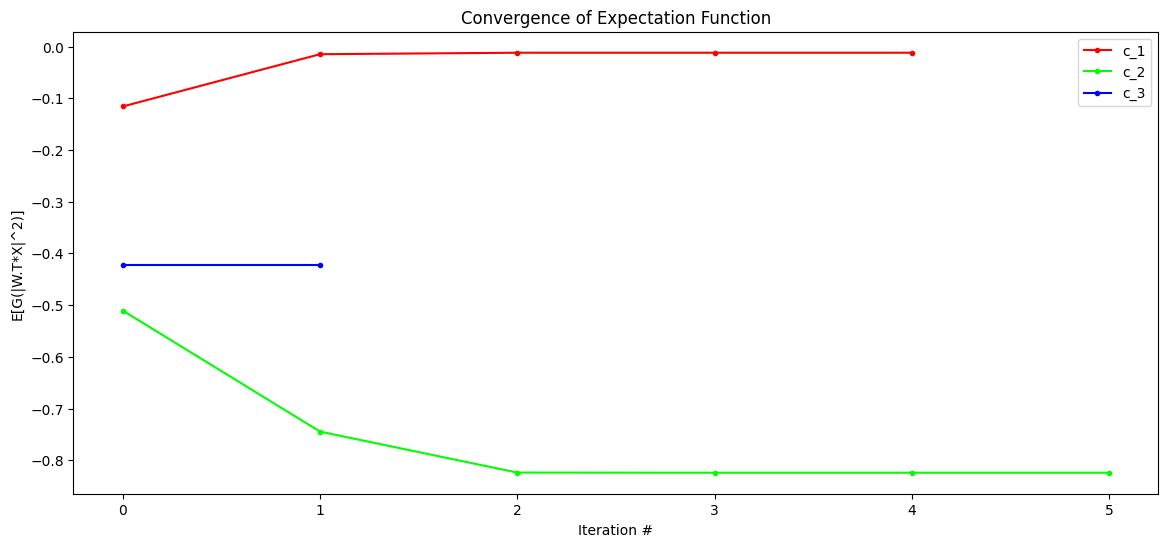

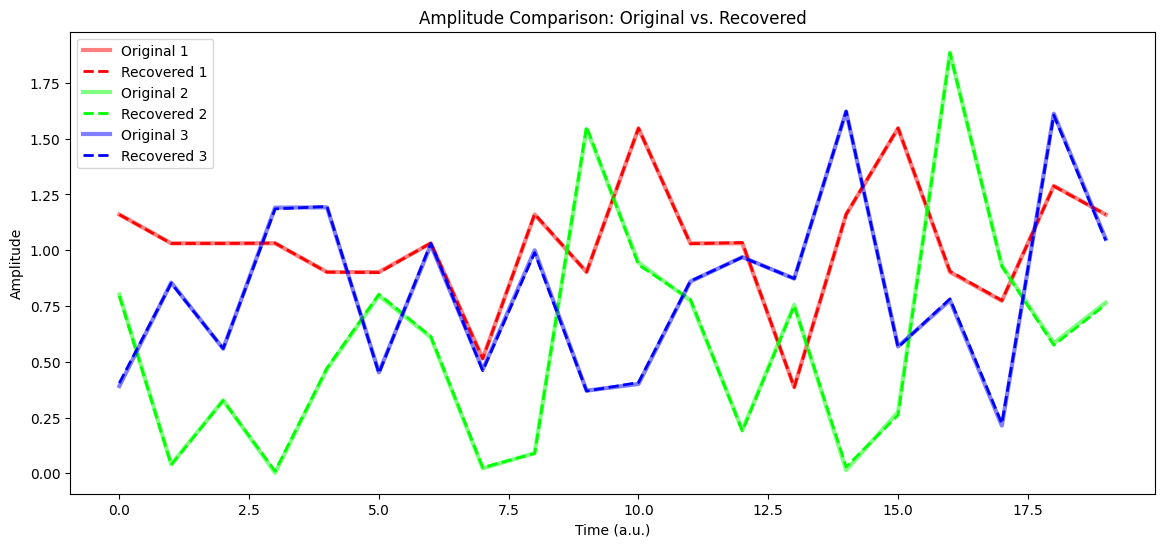

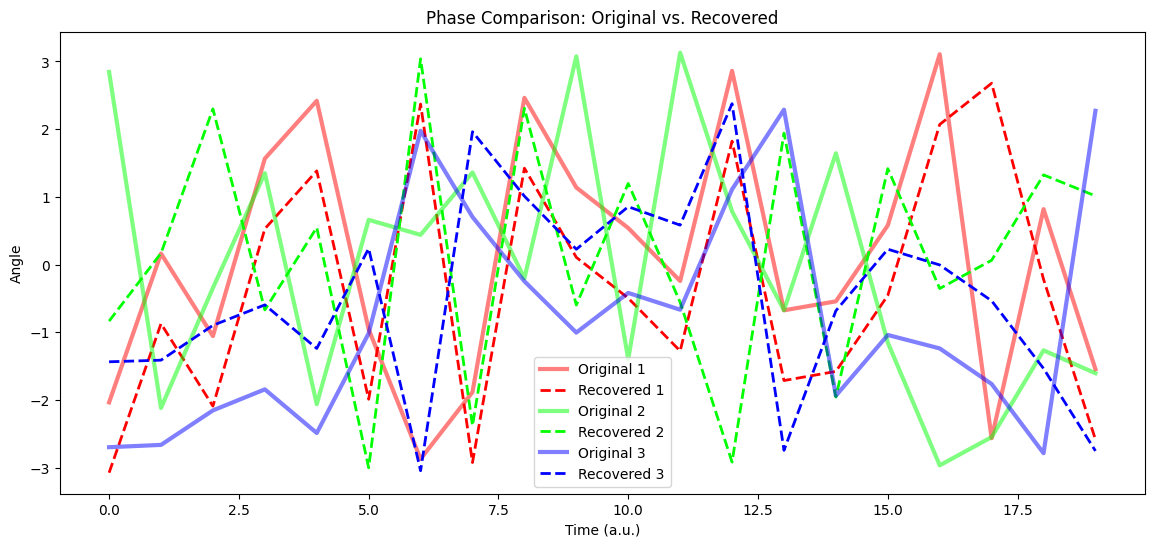

In [4]:
import pdb, os, time, warnings
import numpy as np
from math import log, log10
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.random import rand

plt.ion()

# Number of samples
m = 50000
j = 0

# Generate parameters for different distributions
bino1 = np.maximum(2, np.ceil(20 * rand()))  # Binomial
exp1 = np.ceil(10 * rand())  # Exponential
norm1 = np.ceil(10 * rand())  # Gaussian noise mean
norm2 = np.ceil(10 * rand())  # Gaussian noise std

# Generate independent components (Selecting 3 components)
r = np.random.binomial(bino1, 0.5, size=(1, m))  # Binomial component (Red)
r = np.vstack([r, np.random.exponential(exp1, size=(1, m))])  # Exponential component (Green)
r = np.vstack([r, np.random.normal(norm1, norm2, size=(1, m))])  # Gaussian component (Blue)

# Number of selected components
n = r.shape[0]

# Generate random phase shifts for complex transformation
f = np.random.uniform(-2 * np.pi, 2 * np.pi, size=(n, m))

# Convert signals to complex by applying random phase shifts
S = r * (np.cos(f) + 1j * np.sin(f))

# Standardize signals
S = inv(np.diag(S.std(1))).dot(S)

# Mixing matrix (random complex mixing)
A = rand(n, n) + 1j * rand(n, n)
X = A.dot(S)  # Mixed signals

# Apply Complex FastICA
alg = 'deflation'  # or 'parallel'
K, W, Shat, EG = complex_FastICA(X, max_iter=40, algorithm=alg, n_components=n)

# Compute SSE and SIR
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * log10(((absKAHW * 1. / maximum).sum(0) - 1).mean())

print("\nSSE: %.4f" % SSE)
print("\nSIR: %.4f" % SIR)

# Select a small span of data for visualization
span = 20
start = np.random.randint(m - span)

colors = ['#FF0000', '#00FF00', '#0000FF']  # Red, Green, Blue

# **Convergence Plot**
fig1 = plt.figure(figsize=(14, 6))  # Increased figure size
ax1 = fig1.add_subplot(111)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', color=colors[j], label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
ax1.set_title('Convergence of Expectation Function')
plt.legend(loc='best')
plt.show()

# **Amplitude Plot (Original vs. Recovered)**
fig2 = plt.figure(figsize=(14, 6))  # Larger figure for multiple signals
ax2 = fig2.add_subplot(111)
for j in range(n):
    ax2.plot(np.abs(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
    ax2.plot(np.abs(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')
ax2.set_title('Amplitude Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()

# **Phase Angle Plot (Original vs. Recovered)**
fig3 = plt.figure(figsize=(14, 6))  # Separate figure for phase plot
ax3 = fig3.add_subplot(111)
for j in range(n):
    ax3.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
    ax3.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax3.set_ylabel('Angle')
ax3.set_xlabel('Time (a.u.)')
ax3.set_title('Phase Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()



SSE: 0.0001

SIR: -21.4344


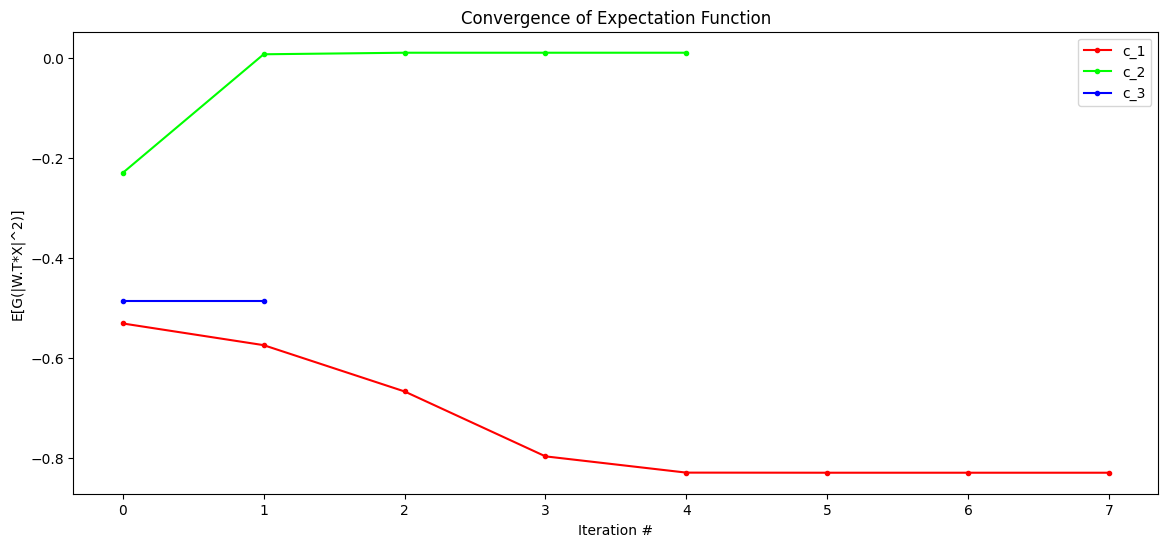

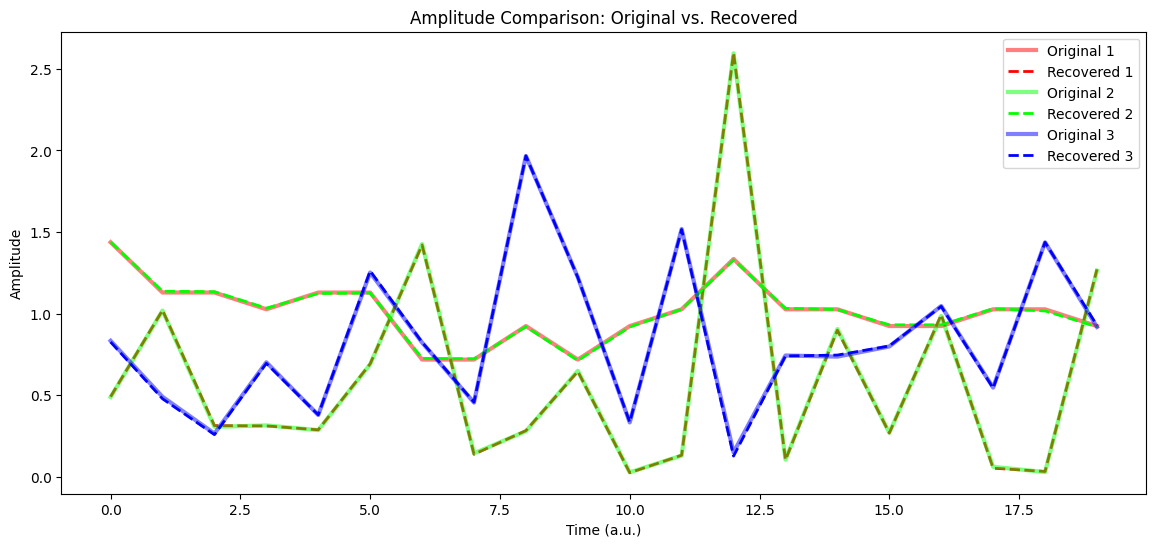

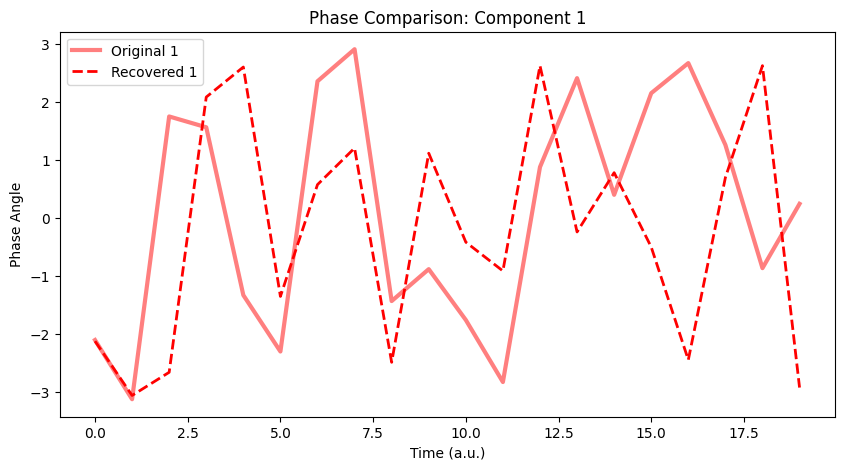

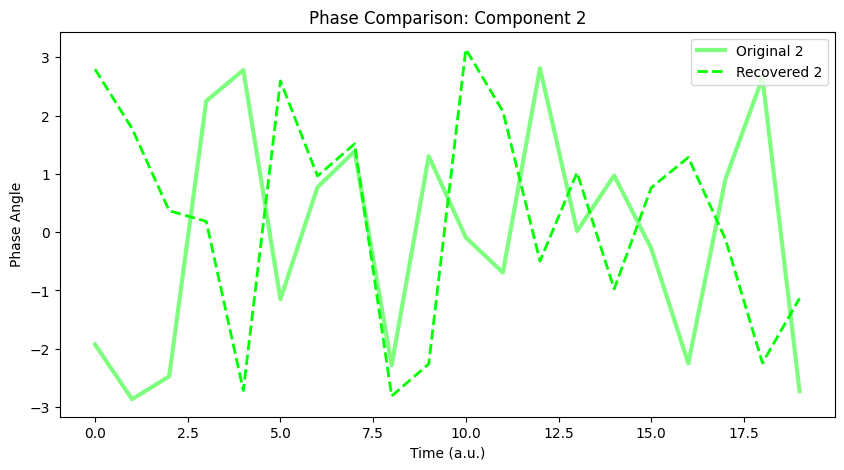

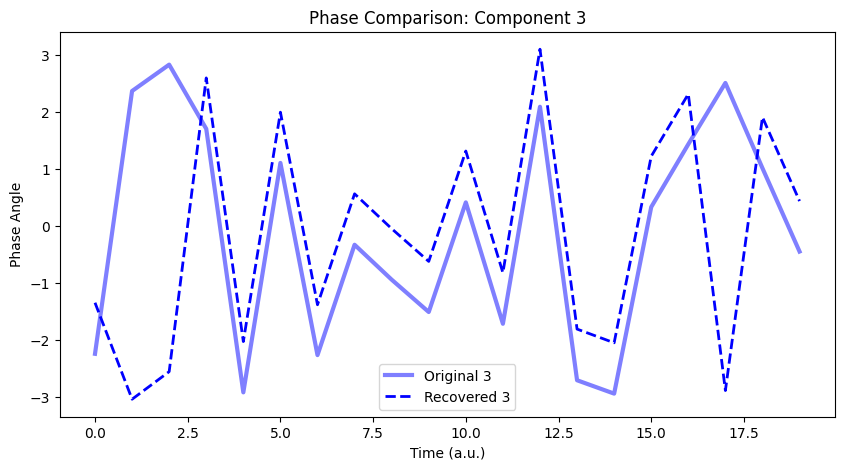

In [5]:
import pdb, os, time, warnings
import numpy as np
from math import log, log10
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy.random import rand

plt.ion()

# Number of samples
m = 50000

# Generate parameters for different distributions
bino1 = np.maximum(2, np.ceil(20 * rand()))  # Binomial
exp1 = np.ceil(10 * rand())  # Exponential
norm1 = np.ceil(10 * rand())  # Gaussian noise mean
norm2 = np.ceil(10 * rand())  # Gaussian noise std

# Generate independent components (Selecting 3 components)
r = np.random.binomial(bino1, 0.5, size=(1, m))  # Binomial component (Red)
r = np.vstack([r, np.random.exponential(exp1, size=(1, m))])  # Exponential component (Green)
r = np.vstack([r, np.random.normal(norm1, norm2, size=(1, m))])  # Gaussian component (Blue)

# Number of selected components
n = r.shape[0]

# Generate random phase shifts for complex transformation
f = np.random.uniform(-2 * np.pi, 2 * np.pi, size=(n, m))

# Convert signals to complex by applying random phase shifts
S = r * (np.cos(f) + 1j * np.sin(f))

# Standardize signals
S = inv(np.diag(S.std(1))).dot(S)

# Mixing matrix (random complex mixing)
A = rand(n, n) + 1j * rand(n, n)
X = A.dot(S)  # Mixed signals

# Apply Complex FastICA
alg = 'deflation'  # or 'parallel'
K, W, Shat, EG = complex_FastICA(X, max_iter=40, algorithm=alg, n_components=n)

# Compute SSE and SIR
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * log10(((absKAHW * 1. / maximum).sum(0) - 1).mean())

print("\nSSE: %.4f" % SSE)
print("\nSIR: %.4f" % SIR)

# Select a small span of data for visualization
span = 20
start = np.random.randint(m - span)

colors = ['#FF0000', '#00FF00', '#0000FF']  # Red, Green, Blue

# **Convergence Plot**
fig1 = plt.figure(figsize=(14, 6))
ax1 = fig1.add_subplot(111)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', color=colors[j], label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
ax1.set_title('Convergence of Expectation Function')
plt.legend(loc='best')
plt.show()

# **Amplitude Plot (Original vs. Recovered)**
fig2 = plt.figure(figsize=(14, 6))
ax2 = fig2.add_subplot(111)
for j in range(n):
    ax2.plot(np.abs(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
    ax2.plot(np.abs(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')
ax2.set_title('Amplitude Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()

# Phase Angle Plots (Each Component in a Separate Figure)
for j in range(n):
    fig = plt.figure(figsize=(10, 5))  # Separate figure for each component
    ax = fig.add_subplot(111)

    ax.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
    ax.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')

    ax.set_ylabel('Phase Angle')
    ax.set_xlabel('Time (a.u.)')
    ax.set_title(f'Phase Comparison: Component {j+1}')

    plt.legend(loc='best', fontsize=10)
    plt.show()


# 2 signals, 1 signal multiplied with on off, added gaussian noise to both signal

Old Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.io import wavfile
from numpy.linalg import inv
from numpy.random import rand
from math import log10

# np.random.seed(42)

m = 50000
fs1, speech1 = wavfile.read('Dev1.wav')
fs2, speech2 = wavfile.read('Dev2.wav')

if(len(speech1)>len(speech2)) :
  m=len(speech2)
else:
  m=len(speech1)

print(m)

#ensure signals have at least m samples
speech1 = speech1[:m].astype(np.float64)
speech2 = speech2[:m].astype(np.float64)

# Create a fixed ON-OFF modulation signal (ON for 1000, OFF for 1000)
block_size = 1000
on_off_signal = np.zeros(m)
for i in range(0, m, 2000):  # Every 2000 samples, turn ON for first 1000
    on_off_signal[i:i+1000] = 1

speech2 = speech2 * on_off_signal

speech1_complex = hilbert(speech1)
speech2_complex = hilbert(speech2)

gaussian_noise1 = np.random.normal(0, 0.01, m)
gaussian_noise2 = np.random.normal(0, 0.01, m)

speech1_complex += gaussian_noise1
speech2_complex += gaussian_noise2

# Stack source signals (complex-valued)
S = np.vstack([speech1_complex, speech2_complex])

# Convert to complex form using random phase shifts
n = S.shape[0]
f = np.random.uniform(-2*np.pi, 2*np.pi, size=(n, m))  # Random phase matrix
S = S * (np.cos(f) + 1j * np.sin(f))  # Convert to complex

# Standardize data
S = inv(np.diag(S.std(axis=1))).dot(S)

# Mixing using a complex mixing matrix
A = rand(n, n) + 1j * rand(n, n)  # Complex mixing matrix
X = A.dot(S)  # Mixed signals

alg = 'deflation'
K, W, Shat, EG = complex_FastICA(X, max_iter=50, algorithm=alg, n_components=n)

# Compute Sum of Squared Errors (SSE) and Signal-to-Interference Ratio (SIR)
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * log10(((absKAHW / maximum).sum(0) - 1).mean())

print("\nSSE: %.4f" % SSE)
print("\nSIR: %.4f" % SIR)

# Select a random segment for visualization
span = 2000  # Number of samples to display
start = np.random.randint(m - span)

### Function to plot signals ###
def plot_signal(signal, title, xlabel="Time", ylabel="Amplitude"):
    plt.figure(figsize=(12, 4))
    plt.plot(np.real(signal), label="Real Part", color='b', alpha=0.5)
    plt.plot(np.imag(signal), label="Imaginary Part", color='r', linestyle="dashed", alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

# Plot Input Signals
plot_signal(S[0, :], "Input Signal 1 (Speech 1)")
plot_signal(S[1, :], "Input Signal 2 (ON-OFF Speech 2)")

# Plot Mixed Signals
plot_signal(X[0, :], "Mixed Signal 1")
plot_signal(X[1, :], "Mixed Signal 2")

# Plot Recovered Signals
plot_signal(Shat[0, :], "Recovered Signal 1 (After FastICA)")
plot_signal(Shat[1, :], "Recovered Signal 2 (After FastICA)")

# Plot ON-OFF signal separately
plt.figure(figsize=(12, 4))
plt.plot(on_off_signal, drawstyle='steps-post', label="ON-OFF Signal", color='g')
plt.title("ON-OFF Modulation Applied to Speech 2")
plt.xlabel("Time")
plt.ylabel("State (1=ON, 0=OFF)")
plt.legend()
plt.show()

# Convergence plot
fig = plt.figure('Complex FastICA')
fig.clf()

ax1 = fig.add_subplot(121)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
plt.legend(loc='best')

# Absolute values of original vs. separated signals
ax2 = fig.add_subplot(222)
ax2.plot(np.abs(S[:, start:start+span]).T, lw=3, alpha=0.2, color='k')
ax2.plot(np.abs(Shat[:, start:start+span]).T, '--', color='r')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')

# Phase angles of original vs. separated signals
ax3 = fig.add_subplot(224)
ax3.plot(np.angle(S[:, start:start+span]).T, lw=3, alpha=0.2, color='k')
ax3.plot(np.angle(Shat[:, start:start+span]).T, '--', color='b')
ax3.set_ylabel('Angle')
ax3.set_xlabel('Time (a.u.)')

plt.show()


New Code

Using 199680 samples

SSE: 0.0000

SIR: -30.1883


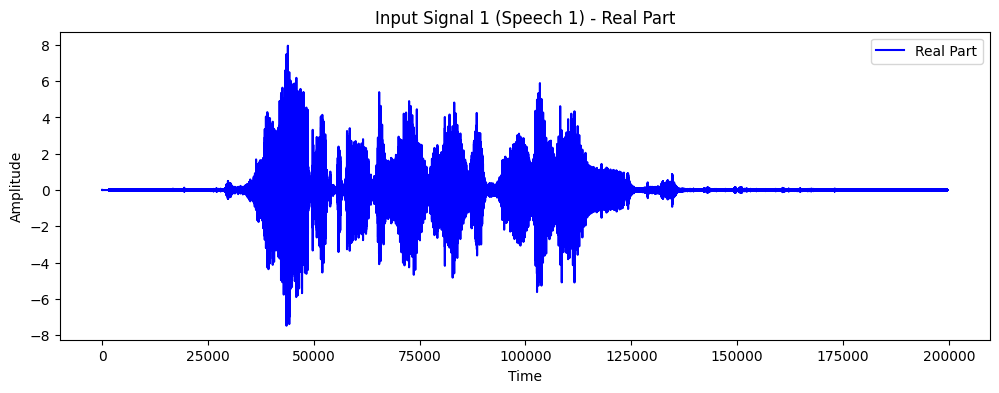

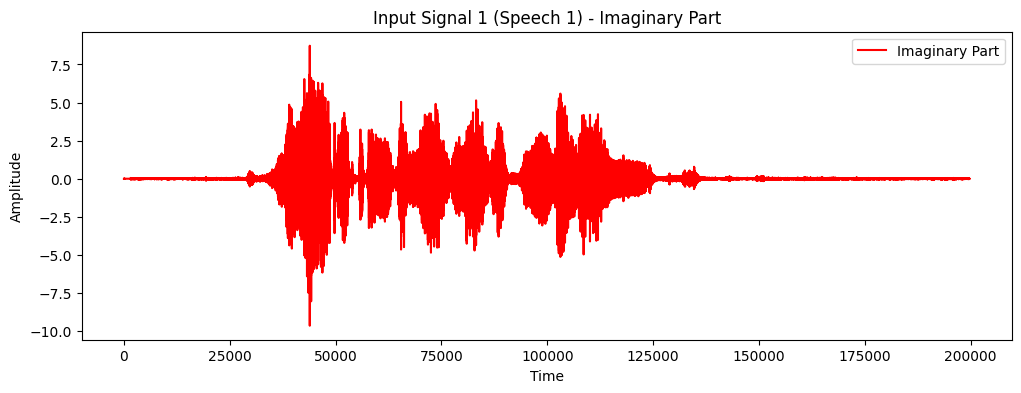

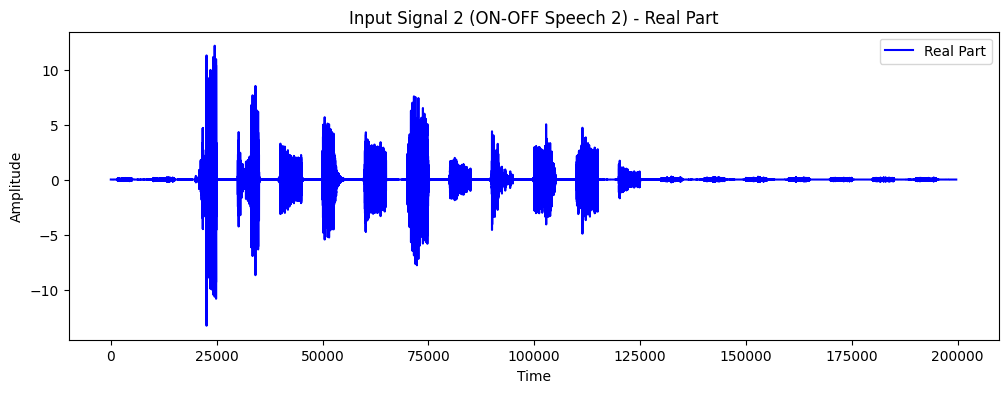

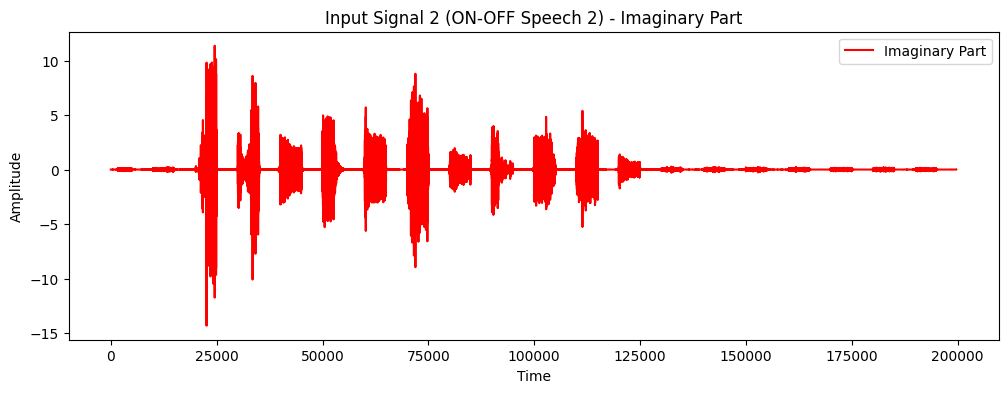

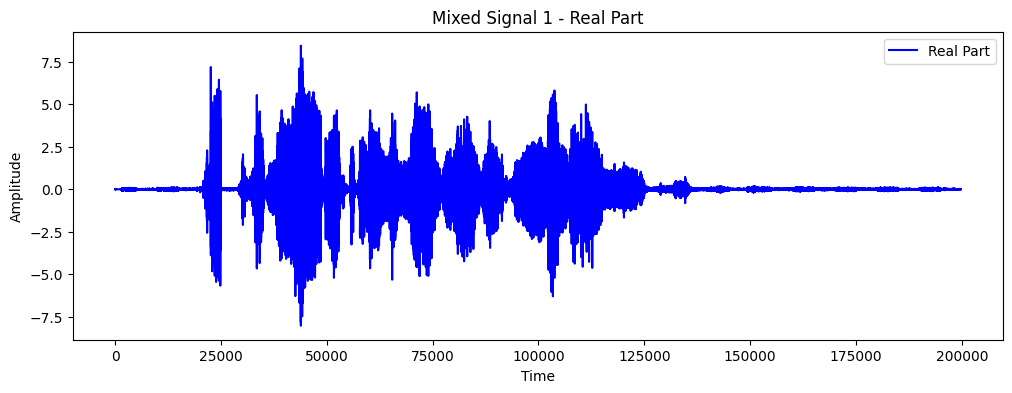

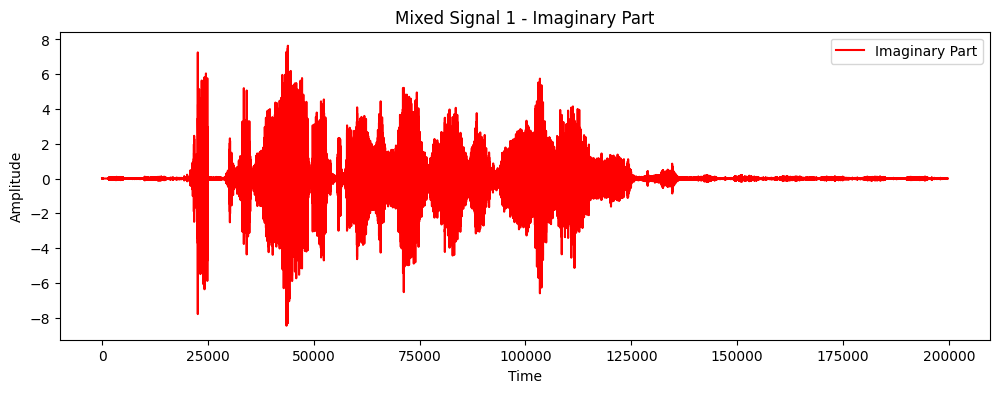

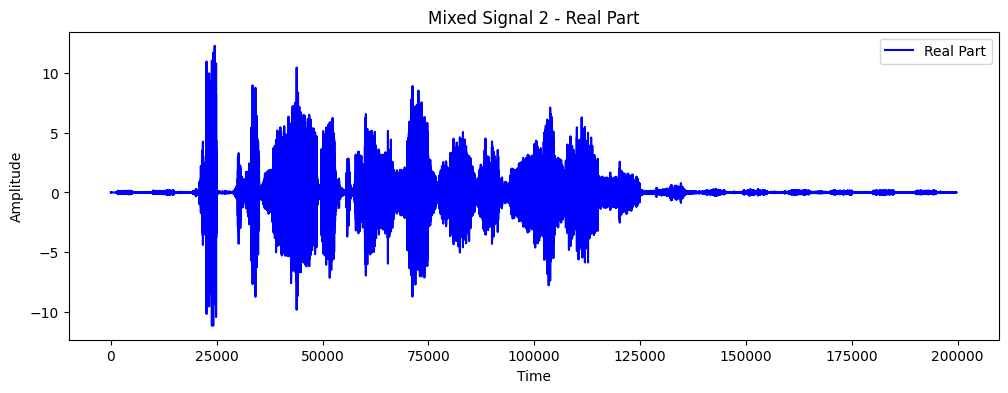

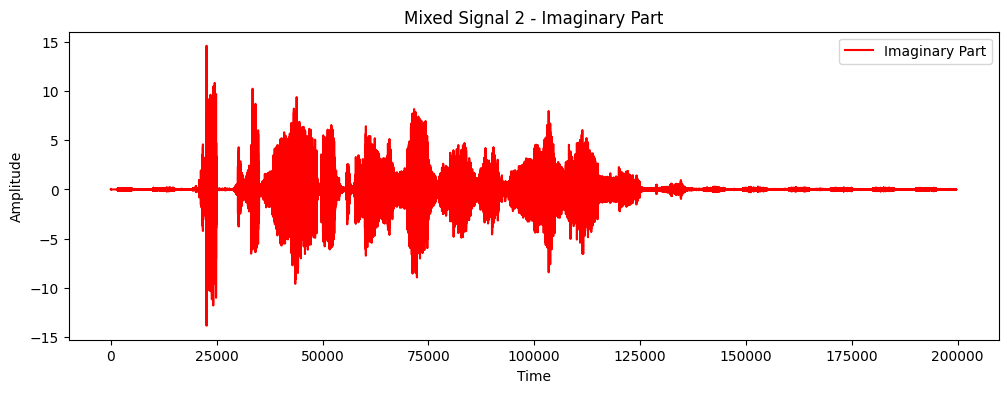

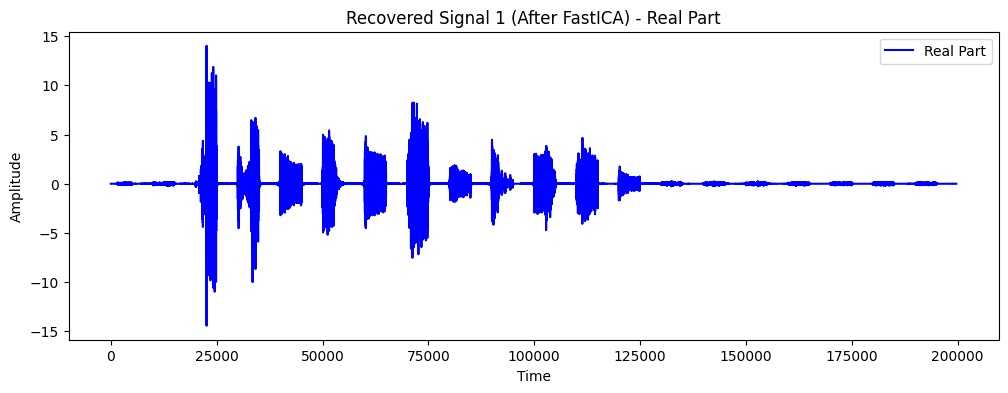

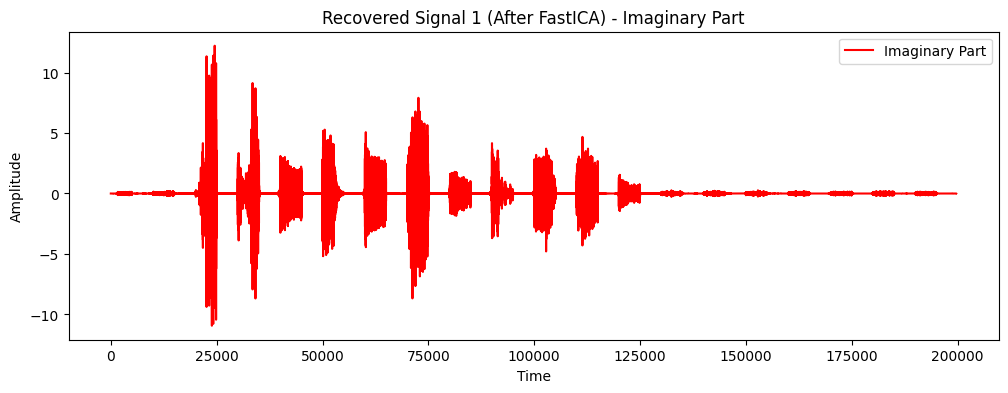

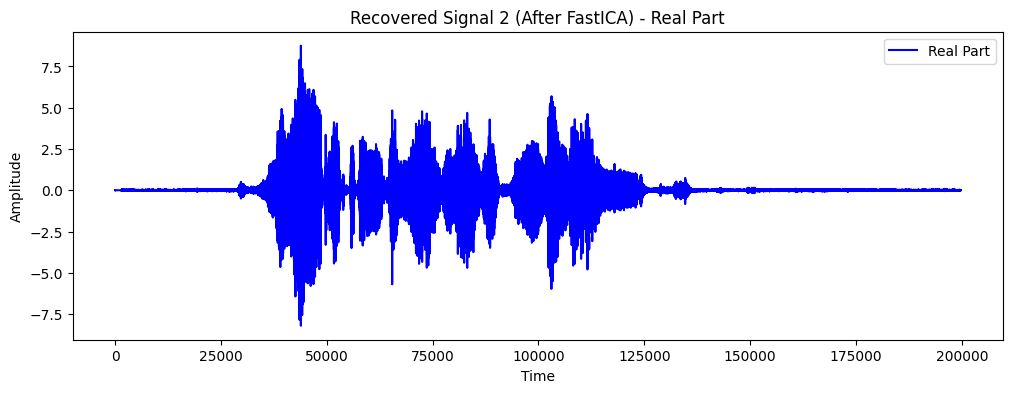

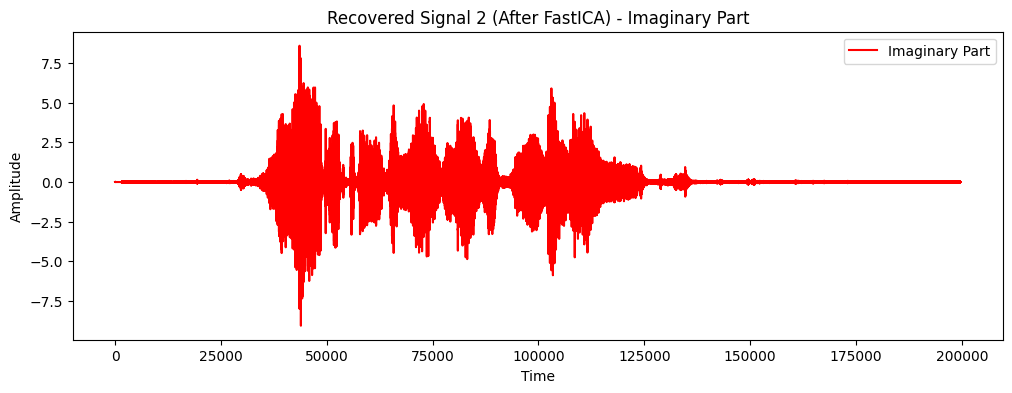

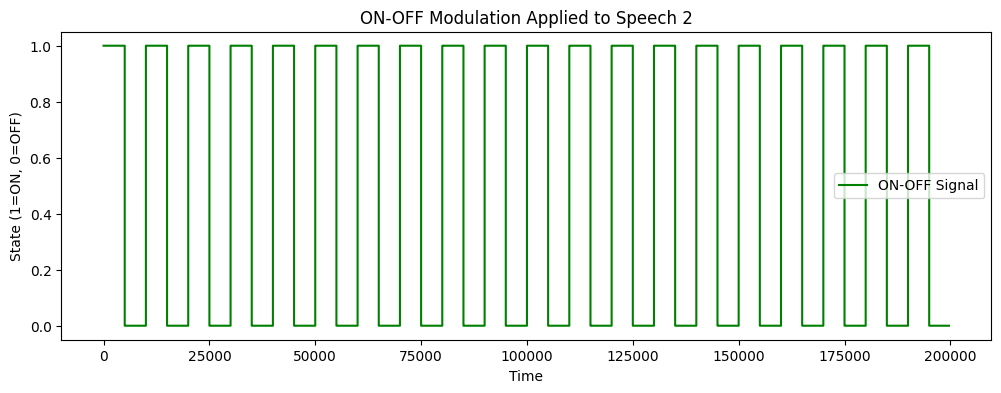

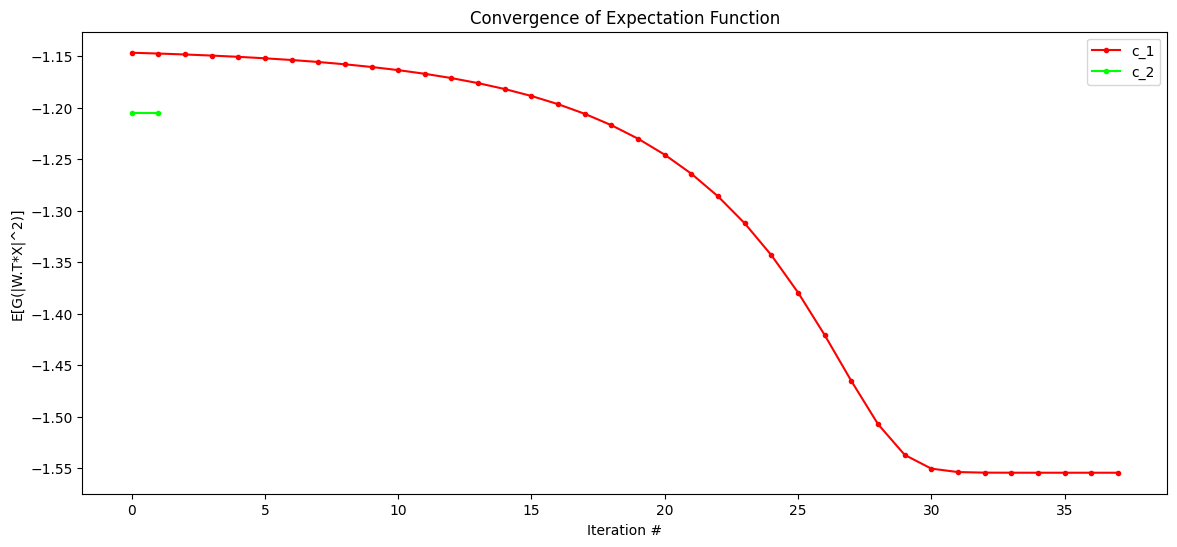

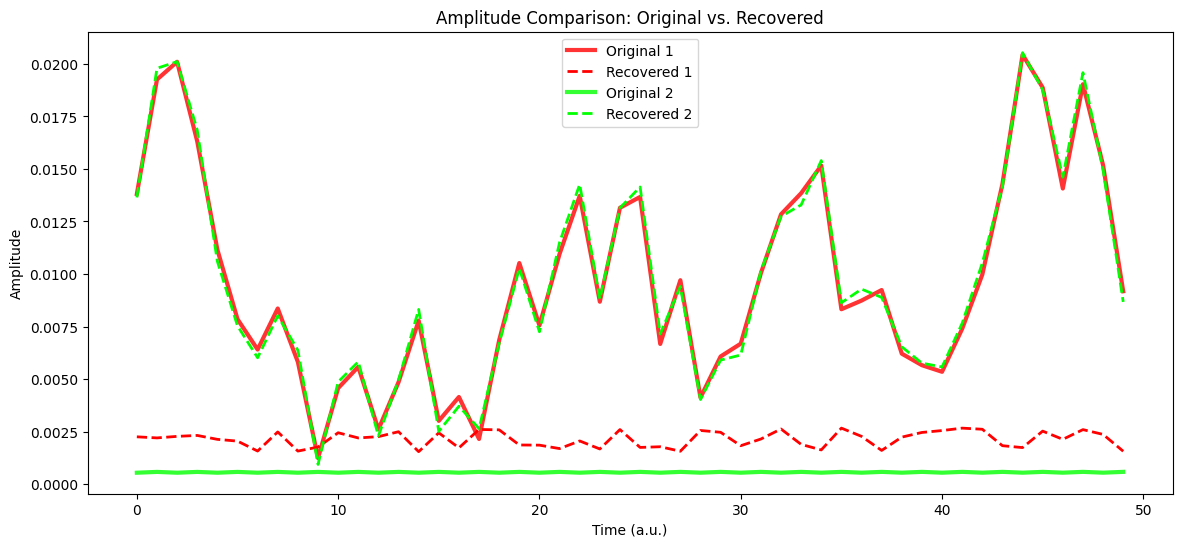

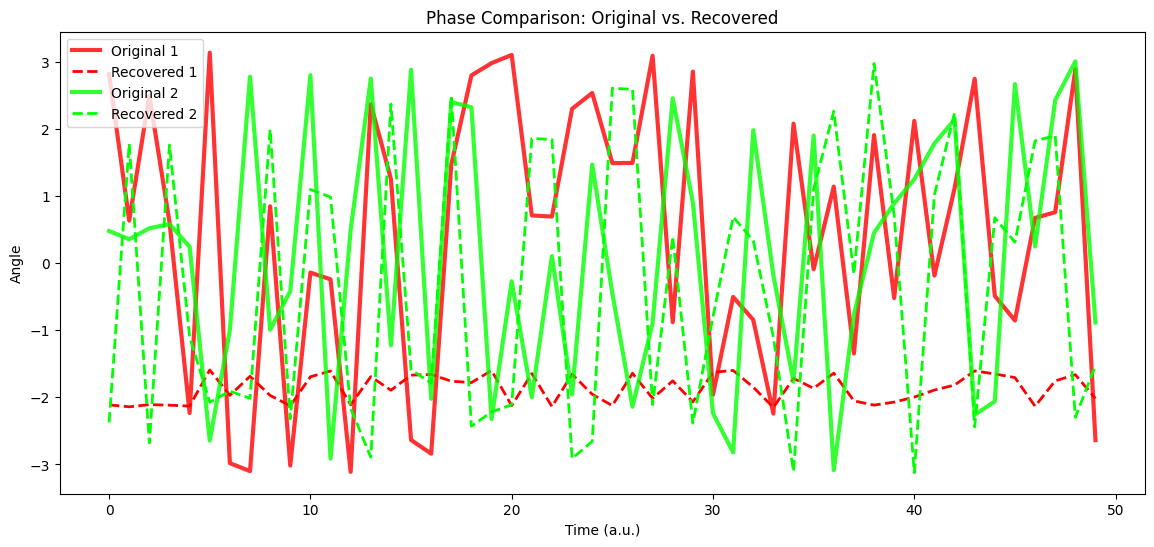

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.io import wavfile
from numpy.linalg import inv
from numpy.random import rand
from math import log10

# Number of samples (determined by shortest speech file)
m = 50000
fs1, speech1 = wavfile.read('Dev1.wav')
fs2, speech2 = wavfile.read('Dev2.wav')

m = min(len(speech1), len(speech2))  # Choose the smaller length
print(f"Using {m} samples")

# Ensure signals have at least 'm' samples
speech1 = speech1[:m].astype(np.float64)
speech2 = speech2[:m].astype(np.float64)

# Create a fixed ON-OFF modulation signal (ON for 5000, OFF for 5000)
block_size = 5000
on_off_signal = np.zeros(m)
for i in range(0, m, 2 * block_size):
    on_off_signal[i:i + block_size] = 1

# Apply ON-OFF modulation to Speech 2
speech2 *= on_off_signal

# Convert to analytic (complex) signals
speech1_complex = hilbert(speech1)
speech2_complex = hilbert(speech2)

# Add Gaussian noise
gaussian_noise1 = np.random.normal(0, 0.01, m)
gaussian_noise2 = np.random.normal(0, 0.01, m)

speech1_complex += gaussian_noise1
speech2_complex += gaussian_noise2

# Stack source signals (complex-valued)
S = np.vstack([speech1_complex, speech2_complex])

# Convert to complex form using random phase shifts
n = S.shape[0]
f = np.random.uniform(-2*np.pi, 2*np.pi, size=(n, m))
S = S * (np.cos(f) + 1j * np.sin(f))

# Standardize data
S = inv(np.diag(S.std(axis=1))).dot(S)

# Mixing using a complex mixing matrix
A = rand(n, n) + 1j * rand(n, n)
X = A.dot(S)

# Apply Complex FastICA
alg = 'deflation'
K, W, Shat, EG = complex_FastICA(X, max_iter=40, algorithm=alg, n_components=n)

# Compute SSE & SIR
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * log10(((absKAHW / maximum).sum(0) - 1).mean())

print(f"\nSSE: {SSE:.4f}")
print(f"\nSIR: {SIR:.4f}")

# Select a small span of data for visualization
span = 50
start = np.random.randint(m - span)

### **Plot Real & Imaginary Parts Separately** ###
def plot_real_imag(signal, title):
    """ Plots real and imaginary parts in separate figures """
    plt.figure(figsize=(12, 4))
    plt.plot(np.real(signal), label="Real Part", color='b')
    plt.title(f"{title} - Real Part")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(np.imag(signal), label="Imaginary Part", color='r')
    plt.title(f"{title} - Imaginary Part")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# **Plot Input Signals**
plot_real_imag(S[0, :], "Input Signal 1 (Speech 1)")
plot_real_imag(S[1, :], "Input Signal 2 (ON-OFF Speech 2)")

# **Plot Mixed Signals**
plot_real_imag(X[0, :], "Mixed Signal 1")
plot_real_imag(X[1, :], "Mixed Signal 2")

# **Plot Recovered Signals**
plot_real_imag(Shat[0, :], "Recovered Signal 1 (After FastICA)")
plot_real_imag(Shat[1, :], "Recovered Signal 2 (After FastICA)")

# **Plot ON-OFF Modulation Signal**
plt.figure(figsize=(12, 4))
plt.plot(on_off_signal, drawstyle='steps-post', label="ON-OFF Signal", color='g')
plt.title("ON-OFF Modulation Applied to Speech 2")
plt.xlabel("Time")
plt.ylabel("State (1=ON, 0=OFF)")
plt.legend()
plt.show()

# Define fixed RGB colors for each component
colors = ['#FF0000', '#00FF00']  # Red, Green

# **Convergence Plot**
fig1 = plt.figure(figsize=(14, 6))
ax1 = fig1.add_subplot(111)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', color=colors[j], label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
ax1.set_title('Convergence of Expectation Function')
plt.legend(loc='best')
plt.show()

# **Amplitude Plot (Original vs. Recovered)**
fig2 = plt.figure(figsize=(14, 6))
ax2 = fig2.add_subplot(111)
for j in range(n):
    ax2.plot(np.abs(S[j, start:start+span]).T, lw=3, alpha=0.8, color=colors[j], label=f'Original {j+1}')
    ax2.plot(np.abs(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')
ax2.set_title('Amplitude Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()

# **Phase Angle Plot (Original vs. Recovered)**
fig3 = plt.figure(figsize=(14, 6))
ax3 = fig3.add_subplot(111)
for j in range(n):
    ax3.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.8, color=colors[j], label=f'Original {j+1}')
    ax3.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax3.set_ylabel('Angle')
ax3.set_xlabel('Time (a.u.)')
ax3.set_title('Phase Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()


# Real Signals (Speech, On-Off, Gaussian Noise)

Total Samples: 206848


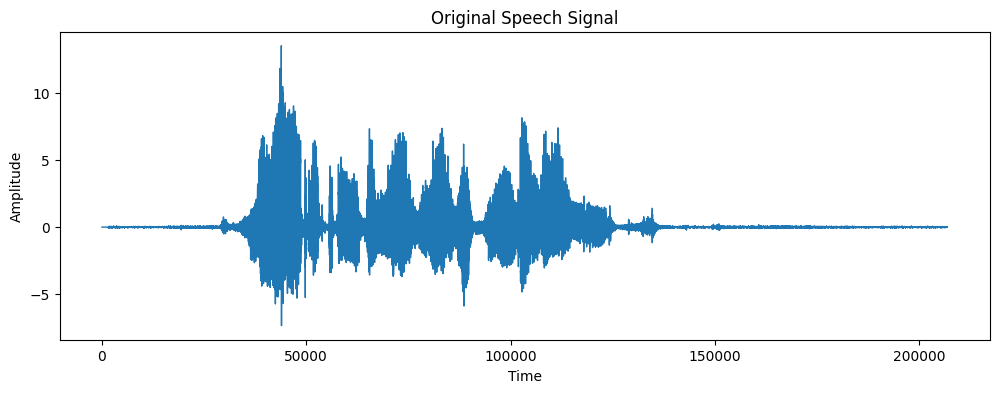

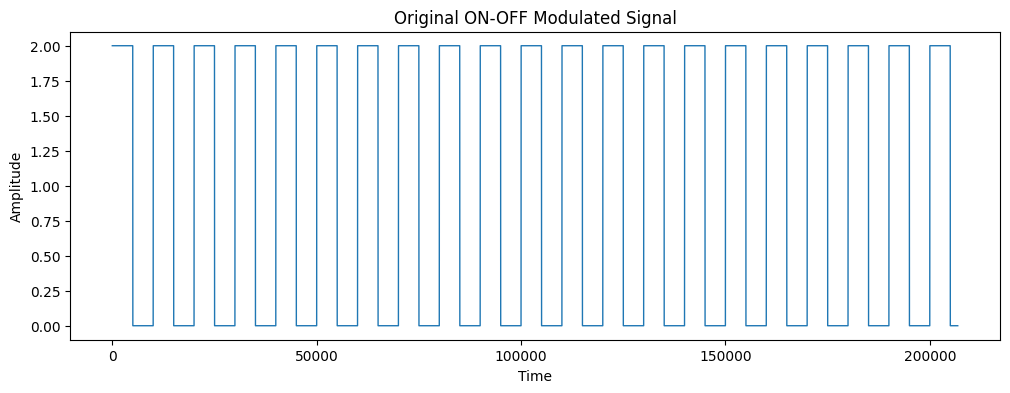

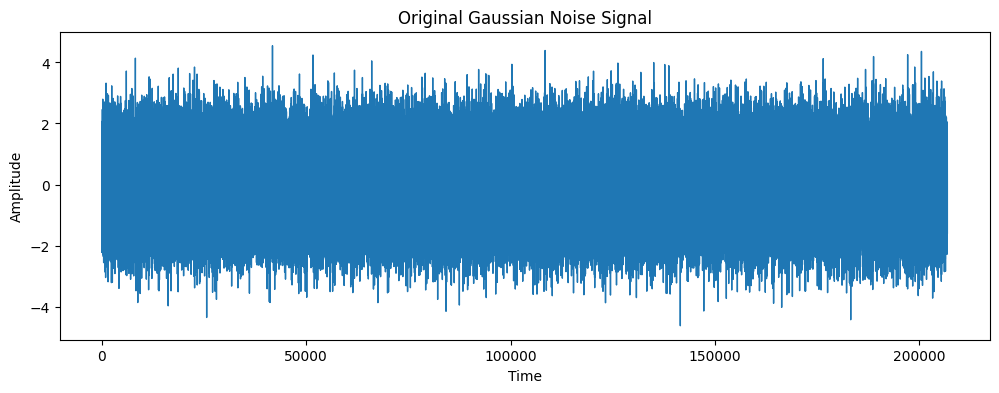

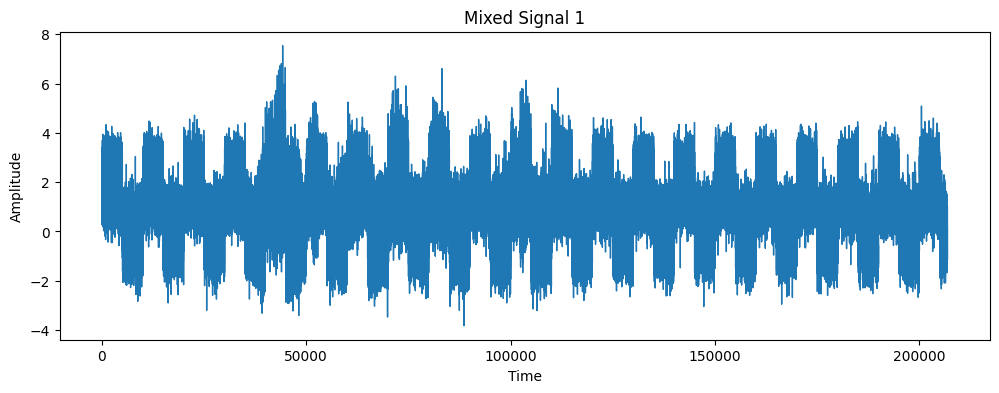

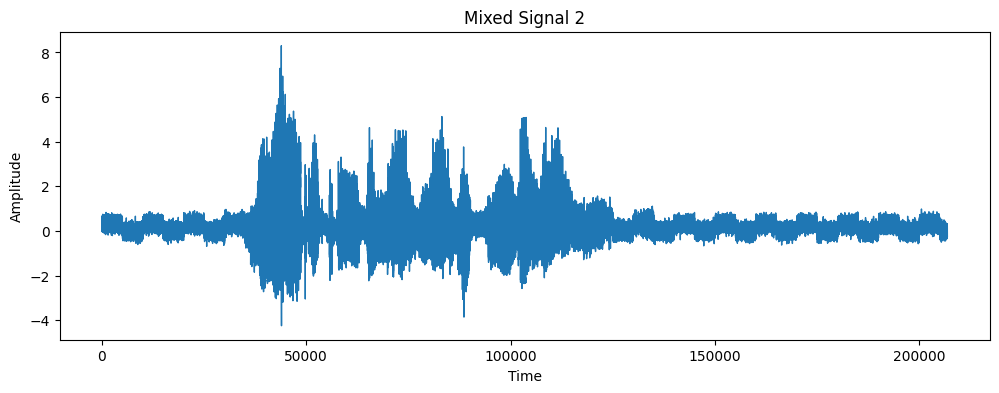

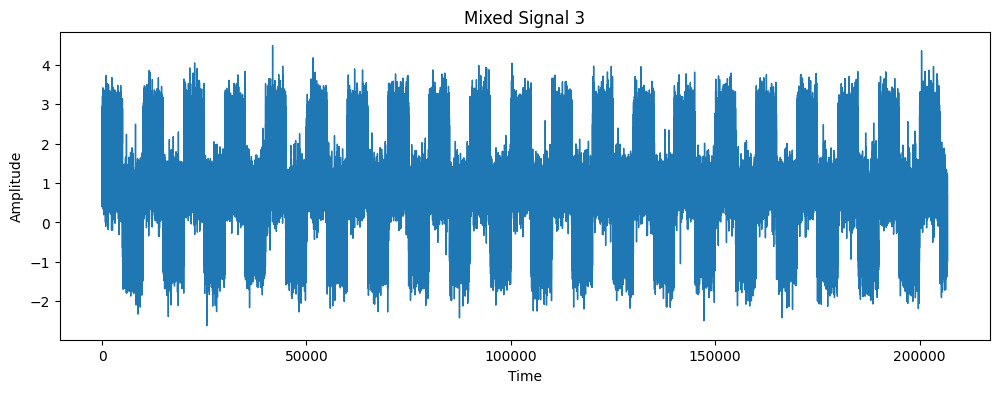

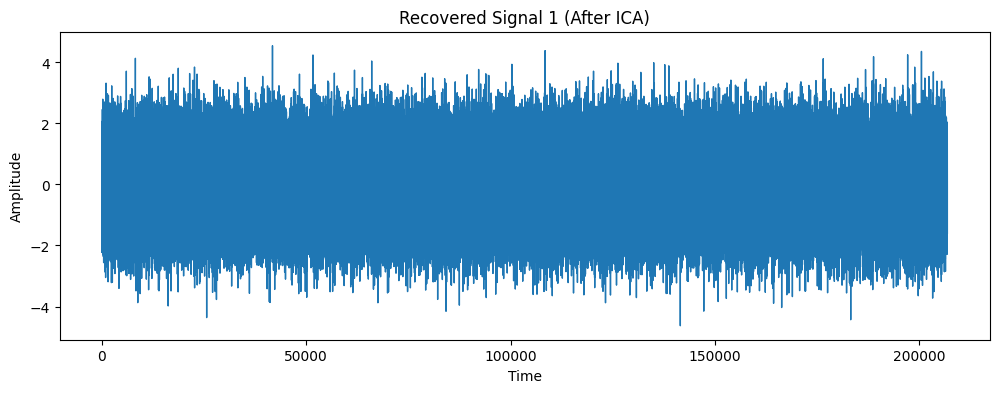

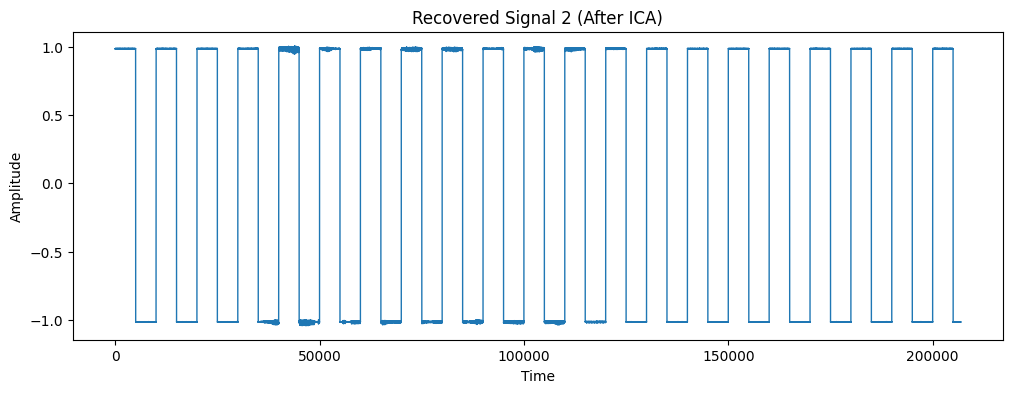

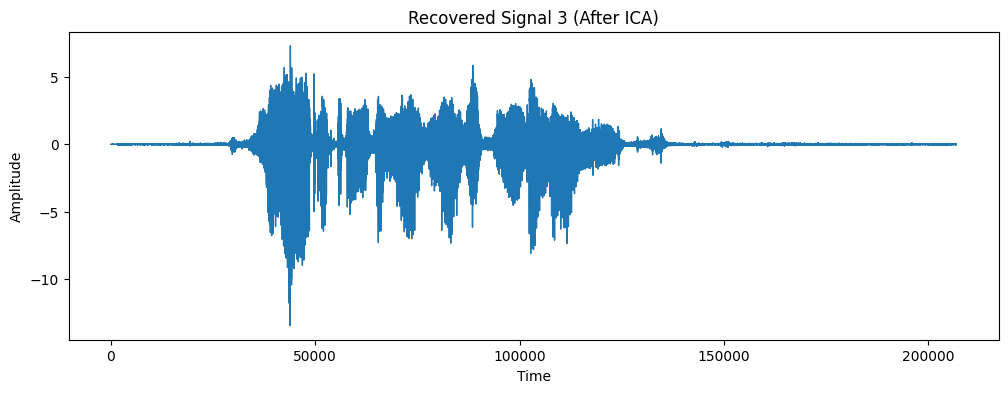


Correlation Matrix:
[[ 1.00000000e+00  2.63353180e-14 -4.55784206e-14]
 [ 2.63353180e-14  1.00000000e+00  3.30354620e-14]
 [-4.55784206e-14  3.30354620e-14  1.00000000e+00]]

--- Updated Correlation Results ---
Best matching component for Speech Signal: Component 3 (Correlation: -1.0000)
Best matching component for On-Off Signal: Component 2 (Correlation: 1.0000)
Best matching component for Noise Signal: Component 1 (Correlation: 1.0000)


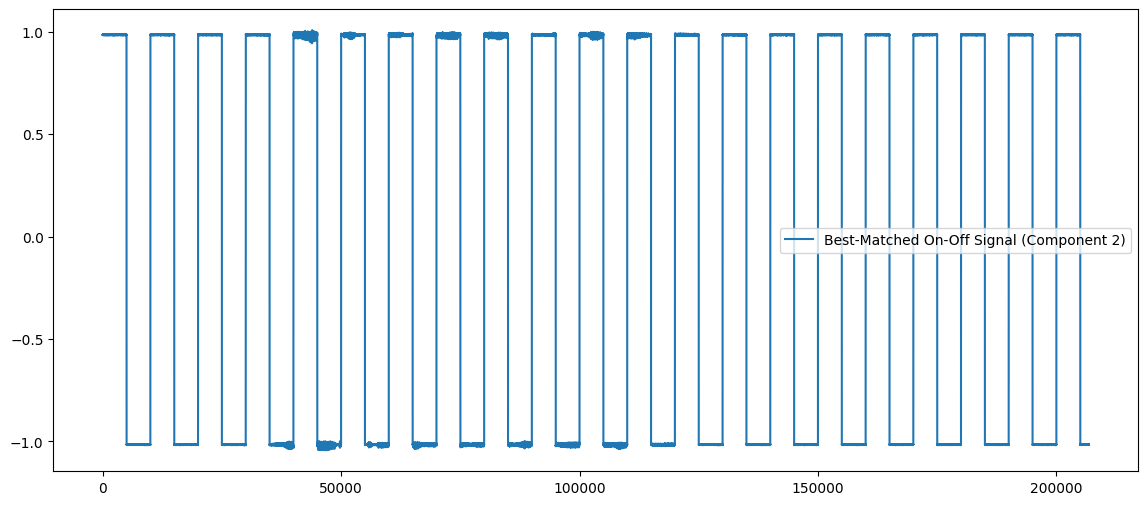

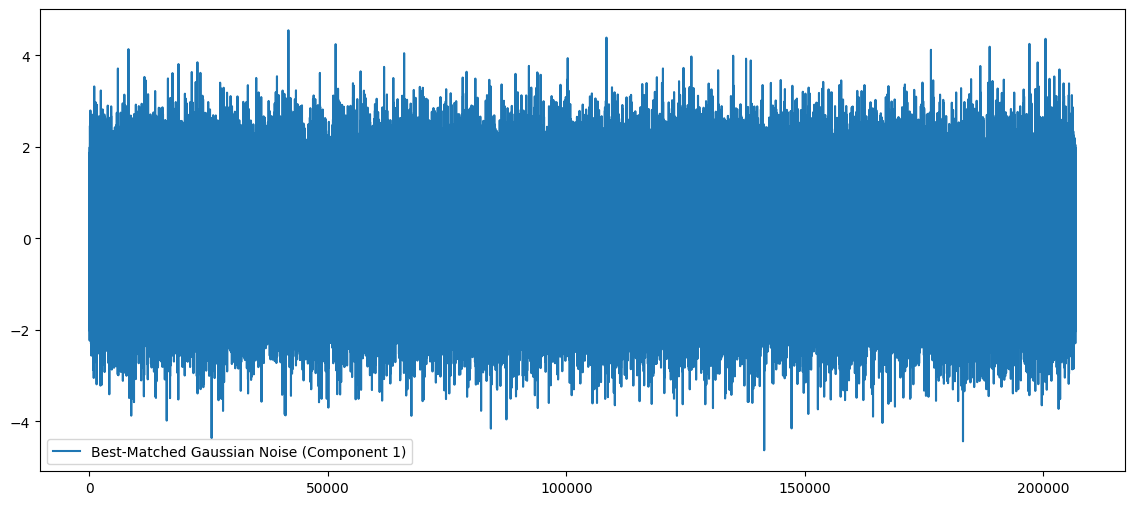

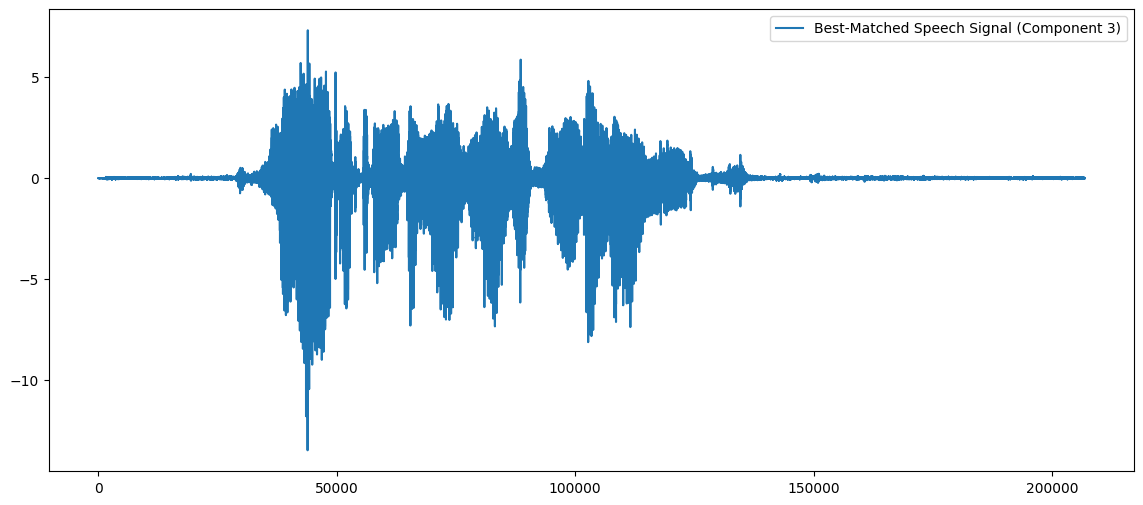

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.decomposition import FastICA

# load speech signal
fs, speech = wavfile.read('Dev1.wav')
speech = speech.astype(np.float64)
m = len(speech)

print(f"Total Samples: {m}")

# Generate ON-OFF Modulated Signal
block_size = 5000
on_off_signal = np.zeros(m)
for i in range(0, m, 2 * block_size):
    on_off_signal[i:i + block_size] = 1

# Generate Gaussian Noise Signal
gaussian_noise = np.random.normal(0, 0.01, m)

S = np.vstack([speech, on_off_signal, gaussian_noise])

# Normalize Each Source to Unit Variance
S /= np.std(S, axis=1, keepdims=True)

# Mixing Process
np.random.seed(42)  # For reproducibility
A = np.random.rand(3, 3)  # Random mixing matrix
X = A.dot(S)  # Mixed signals

# Apply ICA (FastICA)
ica = FastICA(n_components=3, max_iter=200, random_state=42)
Shat = ica.fit_transform(X.T).T  # Recovered signals

# --- Plot Signals ---
def plot_signal(signal, title):
    plt.figure(figsize=(12, 4))
    plt.plot(signal, linewidth=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

# Original Signals
plot_signal(S[0], "Original Speech Signal")
plot_signal(S[1], "Original ON-OFF Modulated Signal")
plot_signal(S[2], "Original Gaussian Noise Signal")

# Mixed Signals
plot_signal(X[0], "Mixed Signal 1")
plot_signal(X[1], "Mixed Signal 2")
plot_signal(X[2], "Mixed Signal 3")

# Recovered Signals (After ICA)
for i in range(3):
    plot_signal(Shat[i], f"Recovered Signal {i + 1} (After ICA)")

# Compute Autocorrelation Matrix for Recovered Signals to check independence
correlation_matrix = np.corrcoef(Shat, rowvar=True)
print("\nCorrelation Matrix:")
print(correlation_matrix)

# --- ORIGINAL Correlation Code ---
# correlations_on_off = [np.corrcoef(on_off_signal, Shat[i, :])[0,1] for i in range(3)]
# correlations_noise = [np.corrcoef(gaussian_noise, Shat[i, :])[0,1] for i in range(3)]
# correlations_speech = [np.corrcoef(speech, Shat[i, :])[0,1] for i in range(3)]

# best_on_off = np.argmax(np.abs(correlations_on_off))
# best_noise = np.argmax(np.abs(correlations_noise))
# best_speech = np.argmax(np.abs(correlations_speech))

# print("\nCorrelations with On-Off Signal:", [np.float64(c) for c in correlations_on_off])
# print("\nCorrelations with Gaussian Noise:", [np.float64(c) for c in correlations_noise])
# print("\nCorrelations with Speech Signal:", [np.float64(c) for c in correlations_speech])

# print(f"\nBest matching component for On-Off signal: Component {best_on_off + 1} (Correlation: {correlations_on_off[best_on_off]:.4f})")
# print(f"Best matching component for Gaussian Noise: Component {best_noise + 1} (Correlation: {correlations_noise[best_noise]:.4f})")
# print(f"Best matching component for Speech Signal: Component {best_speech + 1} (Correlation: {correlations_speech[best_speech]:.4f})")

# --- NEW CLEANER CORRELATION CODE USING S ---
# Compute correlation matrix between original and recovered signals
full_corr = np.corrcoef(S, Shat)
correlations = full_corr[:3, 3:6]  # Shape: (3 original) x (3 recovered)

# Find best matching component for each original signal
best_matches = np.argmax(np.abs(correlations), axis=1)
labels = ['Speech', 'On-Off', 'Noise']

print("\n--- Updated Correlation Results ---")
for i, label in enumerate(labels):
    comp = best_matches[i]
    corr_val = correlations[i, comp]
    print(f"Best matching component for {label} Signal: Component {comp + 1} (Correlation: {corr_val:.4f})")

# --- Plot Best-Matched Separated Signals ---
plt.figure(figsize=(14, 6))
plt.plot(Shat[best_matches[1], :], label=f"Best-Matched On-Off Signal (Component {best_matches[1]+1})")
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(Shat[best_matches[2], :], label=f"Best-Matched Gaussian Noise (Component {best_matches[2]+1})")
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(Shat[best_matches[0], :], label=f"Best-Matched Speech Signal (Component {best_matches[0]+1})")
plt.legend()
plt.show()

# # --- Plot Best-Matched Separated Signals ---
# plt.figure(figsize=(14, 6))
# plt.plot(Shat[best_on_off, :], label=f"Best-Matched On-Off Signal (Component {best_on_off+1})")
# plt.legend()
# plt.show()

# plt.figure(figsize=(14, 6))
# plt.plot(Shat[best_noise, :], label=f"Best-Matched Gaussian Noise (Component {best_noise+1})")
# plt.legend()
# plt.show()

# plt.figure(figsize=(14, 6))
# plt.plot(Shat[best_speech, :], label=f"Best-Matched Speech Signal (Component {best_speech+1})")
# plt.legend()
# plt.show()


# 1 Speech Signal, 1 on-off signal, 1 gaussian noise

Old Code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, square
from scipy.io import wavfile
from numpy.linalg import inv
from numpy.random import rand

plt.ion()

m = 50000  # Number of samples

# # 1. Generate an ON-OFF signal (Square Wave)
# t = np.linspace(0, 1, m)
# on_off_signal = square(2 * np.pi * 5 * t) # 5 Hz Square wave

# Create an ON-OFF signal that switches every 1000 samples
# on_off_signal = np.zeros(m)  # Initialize with all OFF (0)
# on_off_signal[::2000] = 1  # Set ON for the first 1000 samples of every 2000-sample block
# on_off_signal[:1000] = 1  # Ensure the first 1000 samples are ON

# block_size = 1000  # Number of samples per ON/OFF cycle

# # Create an alternating ON (1) and OFF (0) signal
# on_off_signal = np.tile(np.concatenate([np.ones(block_size), np.zeros(block_size)]), m // (2 * block_size))


# # Repeat the pattern for the entire signal
# for i in range(0, m, 2000):
#     on_off_signal[i:i+1000] = 1  # Set every first 1000 samples of a 2000 block to ON

# Create a fixed ON-OFF modulation signal (ON for 5000, OFF for 5000)
block_size = 5000
on_off_signal = np.zeros(m)
for i in range(0, m, 2 * block_size):
    on_off_signal[i:i + block_size] = 1


#Gaussian Noise
gaussian_noise = np.random.normal(0, 0.0333, m)  # σ = 0.0333 ensures ~99.7% values in [-0.1, 0.1]
mean = 0.0          # Mean of the Gaussian distribution
std_dev = 0.01      # Standard deviation of the Gaussian distribution

# Generate Gaussian noise
gaussian_noise = np.random.normal(mean, std_dev,m)

# Clip the noise to the desired amplitude range [-0.1, 0.1]
gaussian_noise = np.clip(gaussian_noise, -0.1, 0.1)

# Load a Speech Signal and Convert to Complex
fs, speech_signal = wavfile.read('Dev1.wav')  # Load a speech WAV file
speech_signal = speech_signal[:m]  # Truncate if needed

# Convert speech to analytic (complex) signal using Hilbert Transform
speech_complex = hilbert(speech_signal)

# Stack all signals together
S = np.vstack([on_off_signal, gaussian_noise, speech_complex])

# Convert to complex form using random phase shifts
n = S.shape[0]
f = np.random.uniform(-2*np.pi, 2*np.pi, size=(n, m))  # Random phase matrix
S = S * (np.cos(f) + 1j * np.sin(f))  # Convert to complex

# Standardize the signals
S = inv(np.diag(S.std(axis=1))).dot(S)

# Plot the Source Signals
# plt.figure(figsize=(12, 8))
# plt.subplot(3, 1, 1)
# plt.plot(np.real(S[0, :]), label="On-Off Signal")
# plt.legend()
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(on_off_signal, drawstyle='steps-post', label="ON-OFF Signal")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.real(S[1, :]), label="Gaussian Noise")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.real(S[2, :]), label="Speech Signal (Real Part)")
plt.legend()
plt.suptitle("Source Signals (Original)")
plt.show()

# Mixing using a complex mixing matrix
A = rand(n, n) + 1j * rand(n, n)
X = A.dot(S)

# Plot the Mixed Signals
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(3, 1, i+1)
    plt.plot(np.real(X[i, :]), label=f"Mixed Signal {i+1}")
    plt.legend()
plt.suptitle("Mixed Signals (After Applying Complex Mixing)")
plt.show()

# Apply Complex FastICA
alg = 'deflation'
K, W, Shat, EG = complex_FastICA(X, max_iter=40, algorithm=alg, n_components=n)

# Compute Signal-to-Interference Ratio (SIR)
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * np.log10(((absKAHW / maximum).sum(0) - 1).mean())

print("\nSSE: %.4f" % SSE)
print("\nSIR: %.4f" % SIR)

# Plot the Separated Signals
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(3, 1, i+1)
    plt.plot(np.real(Shat[i, :]), drawstyle='steps-post', label=f"Separated Signal {i+1}")
    plt.legend()
plt.suptitle("Separated Signals (After Complex FastICA)")
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, i+1)
plt.xlim(0,500)
plt.plot(np.real(Shat[i, :]), drawstyle='steps-post', label=f"Separated Signal {i+1}")
plt.legend()# Retain previous FastICA visualization plots
span = 20
start = np.random.randint(m - span)

fig = plt.figure('fastICA_demo')
fig.clf()

ax1 = fig.add_subplot(121)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
plt.legend(loc='best')

ax2 = fig.add_subplot(222)
ax2.plot(np.abs(S[:, start:start+span]).T, lw=3, alpha=.2, color='k')
ax2.plot(np.abs(Shat[:, start:start+span]).T, '--', color='r')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')

ax3 = fig.add_subplot(224)
ax3.plot(np.angle(S[:, start:start+span]).T, lw=3, alpha=.2, color='k')
ax3.plot(np.angle(Shat[:, start:start+span]).T, '--', color='b')
ax3.set_ylabel('Angle')
ax3.set_xlabel('Time (a.u.)')

plt.show()


New Code

Noise Standardized Min: (-3.815762411557324-1.708614535059643j) Max: (4.262786478157614+0.5069644260026182j)
Speech Standardized Min: (-8.80919020329136-0.87274191273609j) Max: (9.797233026086671-0.16052999524345854j)


<Figure size 1000x400 with 0 Axes>

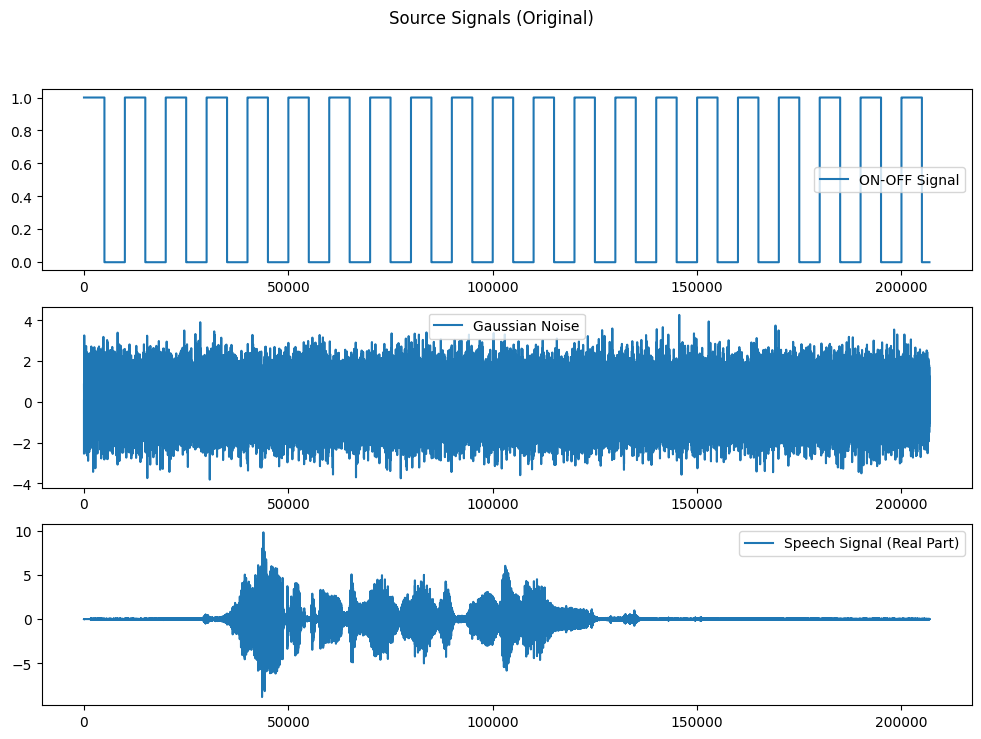

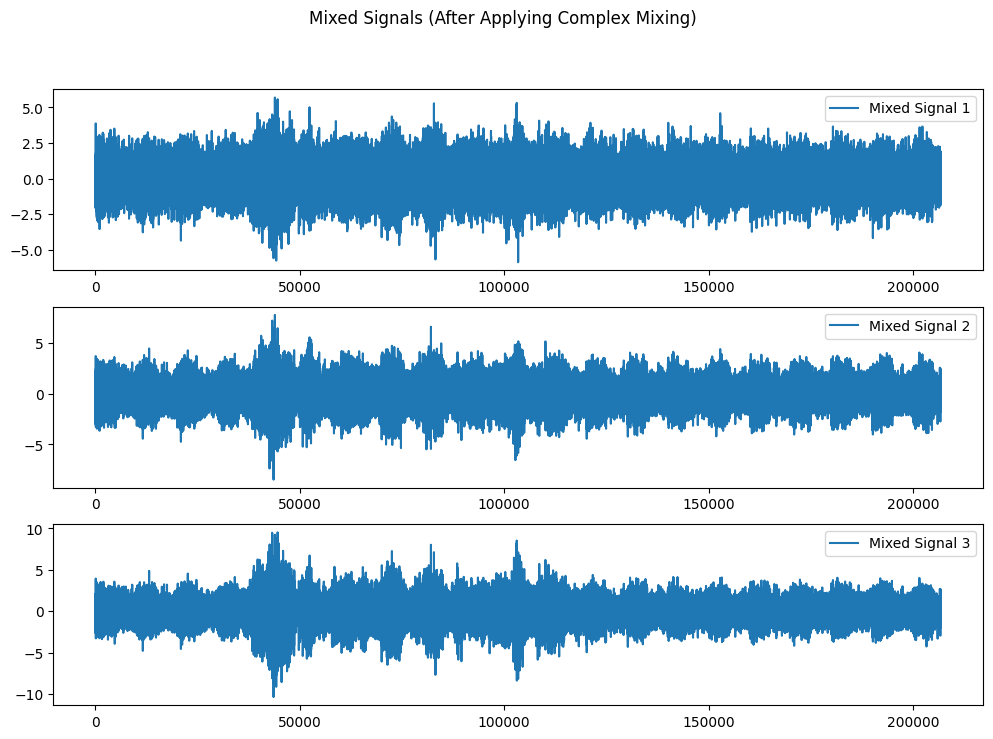


SSE: 0.0000

SIR: -27.6943
Variances of separated components: [np.float64(0.5000044202641588), np.float64(0.4997067962087035), np.float64(0.49901819705741096)]


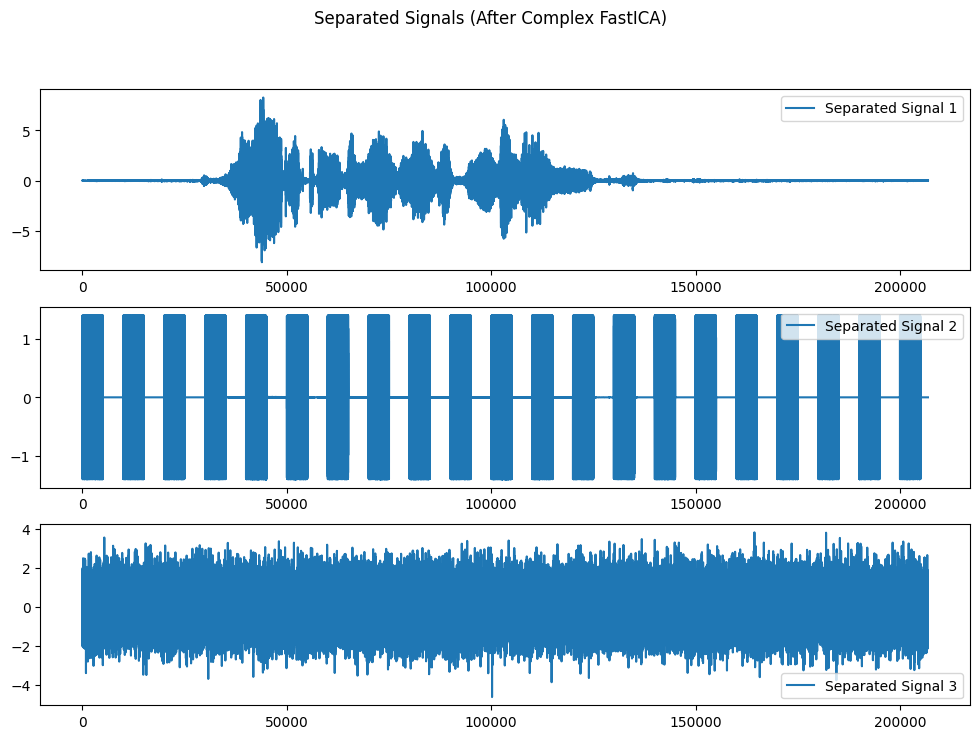

Correlations: [np.float64(-0.0023131418816622015), np.float64(0.00013455178388940587), np.float64(0.00026209096560513234)]
Best matching component for on-off signal: Component 1
Correlation value: -0.0023


/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


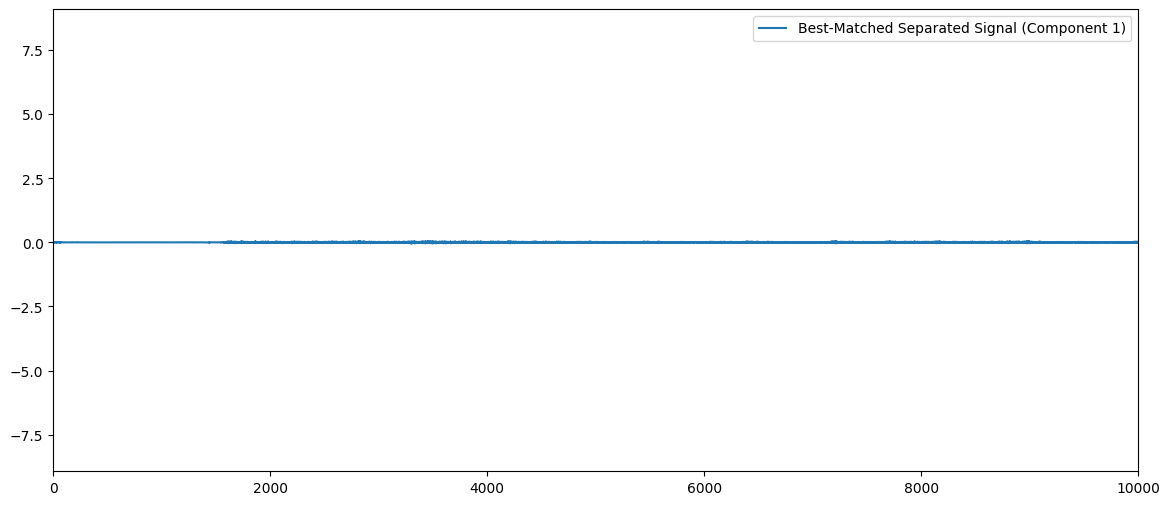

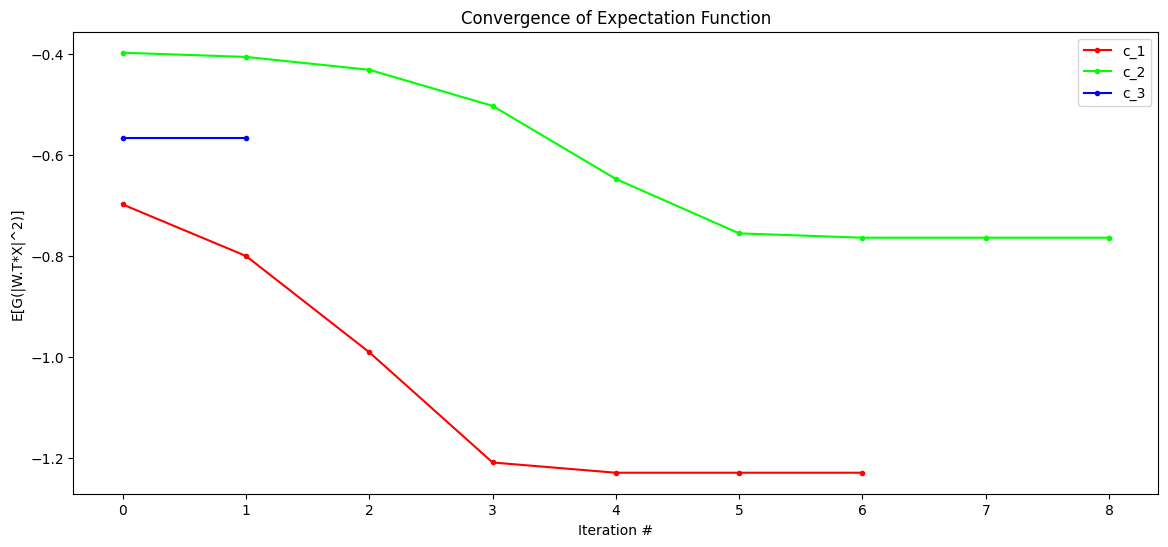

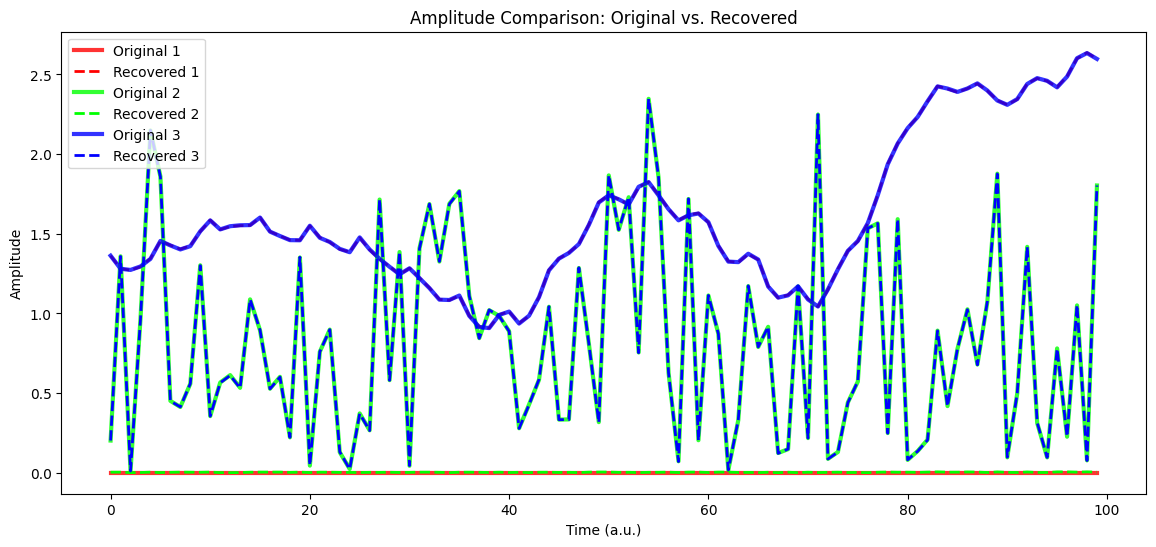

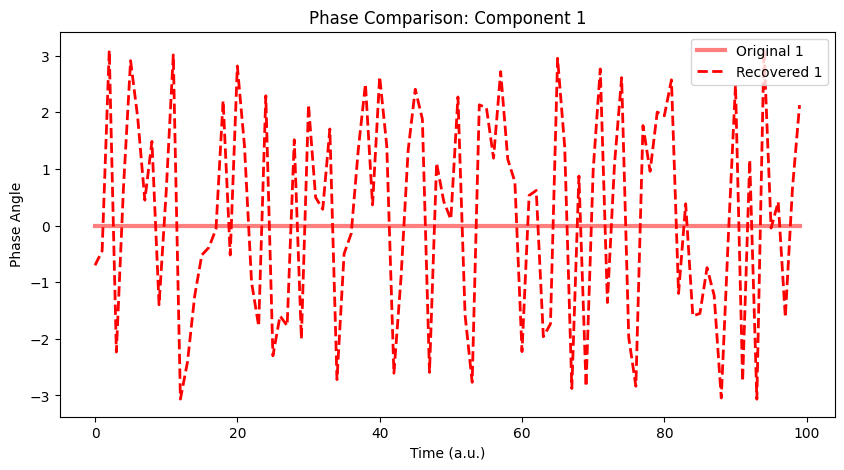

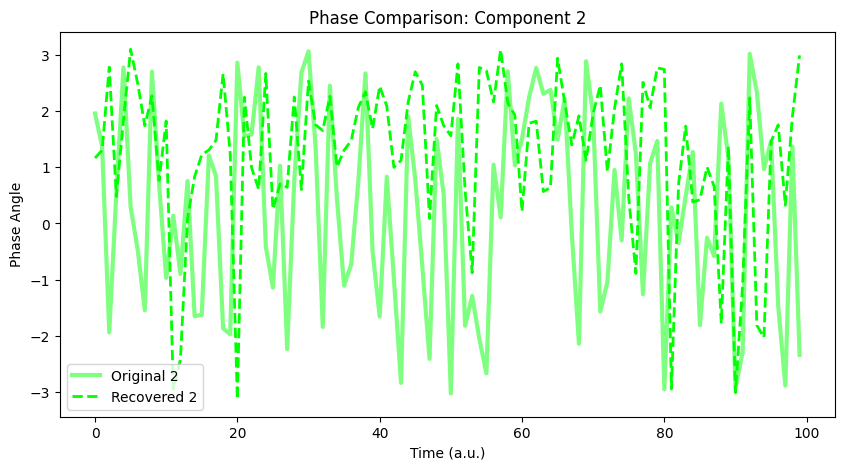

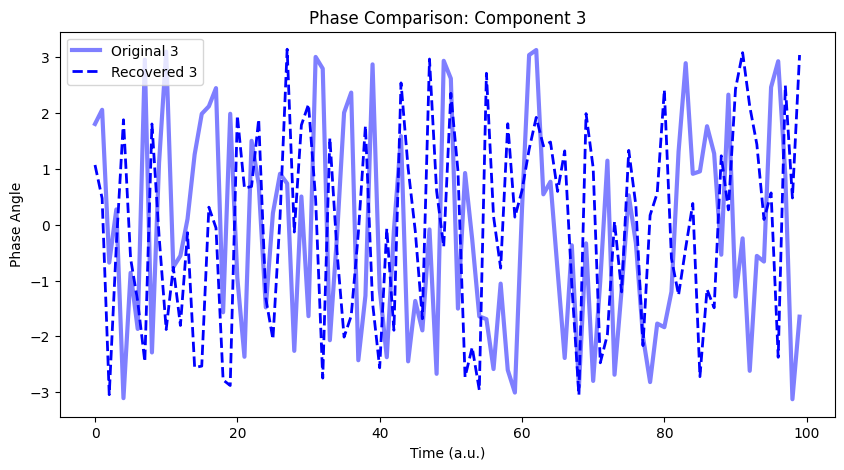

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.io import wavfile
from numpy.linalg import inv
from numpy.random import rand

plt.ion()

# Load a Speech Signal and Convert to Complex
fs, speech_signal = wavfile.read('Dev1.wav')
m = len(speech_signal)

# Compute standard deviation of the real speech signal
std_real = np.std(speech_signal)
# print(f"Standard deviation of real speech signal: {std_real:.4f}")

# Convert speech to analytic (complex) signal using Hilbert Transform
speech_complex = hilbert(speech_signal)

# Compute standard deviation of the complex speech signal
std_complex = np.std(speech_complex)
# print(f"Standard deviation of complex speech signal: {std_complex:.4f}")

# Create an On-Off Signal
block_size = 5000
on_off_signal = np.zeros(m)
for i in range(0, m, 2 * block_size):
    on_off_signal[i:i + block_size] = 1

# Gaussian Noise
noise_std=std_real/2
# print("noise std is : ",noise_std)
#or std=0.0333
gaussian_noise = np.random.normal(0,noise_std, m)
plt.figure(figsize=(10, 4))
# plt.plot(gaussian_noise, label="Raw Gaussian Noise")
# plt.legend()
# plt.show()

# Stack all signals together
S = np.vstack([on_off_signal, gaussian_noise, speech_complex])

# Convert to complex form using random phase shifts
n = S.shape[0]
f = np.random.uniform(-2*np.pi, 2*np.pi, size=(n, m))
S = S * (np.cos(f) + 1j * np.sin(f))

# Standardize the signals
S = inv(np.diag(S.std(axis=1))).dot(S)
# S /= np.abs(S).std(axis=1, keepdims=True)

# print("Min:", np.min(gaussian_noise), "Max:", np.max(gaussian_noise))
print("Noise Standardized Min:", np.min(S[1, :]), "Max:", np.max(S[1, :]))
print("Speech Standardized Min:", np.min(S[2, :]), "Max:", np.max(S[2, :]))

# Plot the Source Signals
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(on_off_signal, drawstyle='steps-post', label="ON-OFF Signal")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.real(S[1, :]), label="Gaussian Noise")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.real(S[2, :]), label="Speech Signal (Real Part)")
plt.legend()
plt.suptitle("Source Signals (Original)")
plt.show()

# Mixing using a complex mixing matrix
A = rand(n, n) + 1j * rand(n, n)
X = A.dot(S)

# Plot the Mixed Signals
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(3, 1, i+1)
    plt.plot(np.real(X[i, :]), label=f"Mixed Signal {i+1}")
    plt.legend()
plt.suptitle("Mixed Signals (After Applying Complex Mixing)")
plt.show()

# Apply Complex FastICA
alg = 'deflation'
K, W, Shat, EG = complex_FastICA(X, max_iter=40, algorithm=alg, n_components=n)

# Compute Signal-to-Interference Ratio (SIR)
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * np.log10(((absKAHW / maximum).sum(0) - 1).mean())

print("\nSSE: %.4f" % SSE)
print("\nSIR: %.4f" % SIR)

variances = [np.var(np.real(Shat[i, :])) for i in range(n)]
print("Variances of separated components:", variances)

# Plot the Separated Signals
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(3, 1, i+1)
    plt.plot(np.real(Shat[i, :]), label=f"Separated Signal {i+1}")
    plt.legend()
plt.suptitle("Separated Signals (After Complex FastICA)")
plt.show()

# Automatically identify the best-matching on-off component
correlations = [np.corrcoef(on_off_signal, np.real(Shat[i, :]))[0,1] for i in range(n)]
best_match_index = np.argmax(np.abs(correlations))
print("Correlations:", correlations)

print(f"Best matching component for on-off signal: Component {best_match_index+1}")
print(f"Correlation value: {correlations[best_match_index]:.4f}")

# Plot the Best-Matched Separated Signal
plt.figure(figsize=(14, 6))
plt.xlim(0, 10000)
plt.plot(Shat[best_match_index, :], label=f"Best-Matched Separated Signal (Component {best_match_index+1})")
plt.legend()
plt.show()

# Retain previous FastICA visualization plots
span = 100
start = np.random.randint(m - span)

colors = ['#FF0000', '#00FF00', '#0000FF']  # Red, Green, Blue

# **Convergence Plot**
fig1 = plt.figure(figsize=(14, 6))
ax1 = fig1.add_subplot(111)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', color=colors[j], label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
ax1.set_title('Convergence of Expectation Function')
plt.legend(loc='best')
plt.show()

# **Amplitude Plot (Original vs. Recovered)**
fig2 = plt.figure(figsize=(14, 6))
ax2 = fig2.add_subplot(111)
for j in range(n):
    ax2.plot(np.abs(S[j, start:start+span]).T, lw=3, alpha=0.8, color=colors[j], label=f'Original {j+1}')
    ax2.plot(np.abs(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')
ax2.set_title('Amplitude Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()

# **Phase Angle Plot (Original vs. Recovered)**
# fig3 = plt.figure(figsize=(14, 6))
# ax3 = fig3.add_subplot(111)
# for j in range(n):
#     ax3.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
#     ax3.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
# ax3.set_ylabel('Angle')
# ax3.set_xlabel('Time (a.u.)')
# ax3.set_title('Phase Comparison: Original vs. Recovered')
# plt.legend(loc='best', fontsize=10)
# plt.show()
# **Phase Angle Plots (Separate for Each Component)**
for j in range(n):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ax.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
    ax.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')

    ax.set_ylabel('Phase Angle')
    ax.set_xlabel('Time (a.u.)')
    ax.set_title(f'Phase Comparison: Component {j+1}')
    plt.legend(loc='best', fontsize=10)

    plt.show()


# Computing correlation coefficient to differentiate between recovered components

Noise Standardized Min: (-7.190827409426983-0.500919902110149j) Max: (6.654939771152133-0.37676118897446825j)
Speech Standardized Min: (-9.85472126921713+1.967496843232532j) Max: (9.642879491761768-1.1819371077515757j)


<Figure size 1000x400 with 0 Axes>

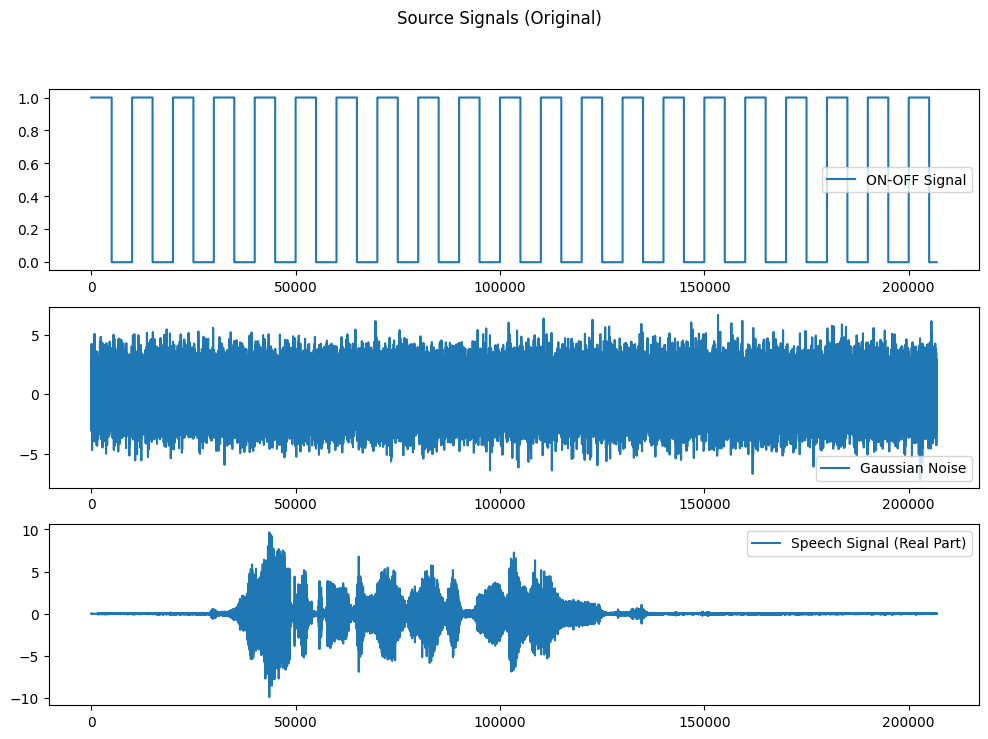

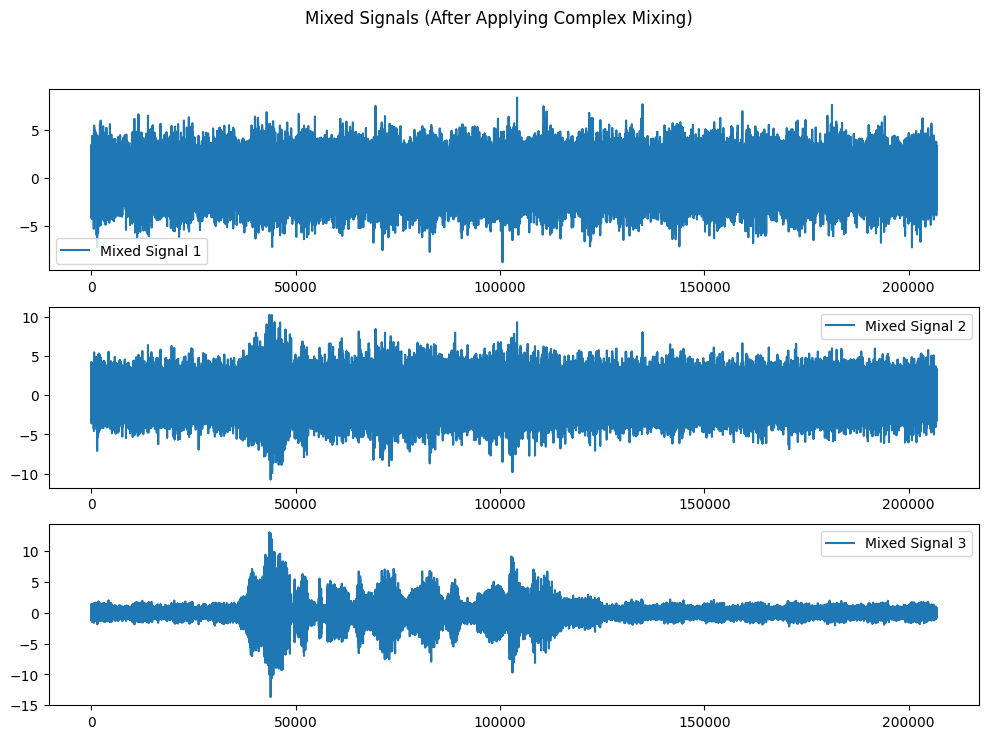


SSE: 0.2746

SIR: -28.0914
Variances of separated components: [np.float64(0.5000075516894625), np.float64(0.5008692450066643), np.float64(0.49875613415329534)]


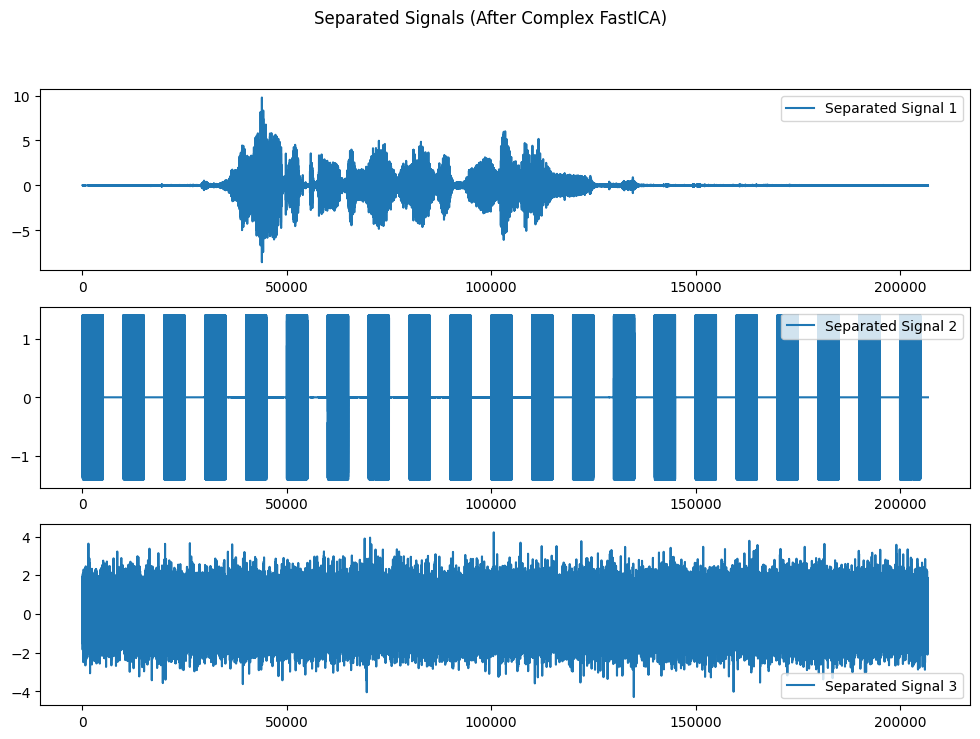

Correlation Matrix:
[[ 1.00000000e+00 -1.02197787e-03  1.36896834e-04]
 [-1.02197787e-03  1.00000000e+00 -2.21167804e-03]
 [ 1.36896834e-04 -2.21167804e-03  1.00000000e+00]]

Correlations with On-Off Signal: [np.complex128(-0.0014341426021262902+0.0001235146207263155j), np.complex128(0.5124668407258931-0.48811158594863446j), np.complex128(-0.0008226571066601648+0.001403582171484732j)]

Correlations with Gaussian Noise: [np.complex128(-0.0036126592720749015-0.0017817914926808673j), np.complex128(0.00010771241848619629-0.0012452323530715288j), np.complex128(-0.4988083136222332+0.49995043496843483j)]

Correlations with Speech Signal: [np.float64(0.43925662749663724), np.float64(-0.0014628025218325867), np.float64(0.005519374860050732)]

Best matching component for On-Off signal: Component 2 (Correlation: 0.5125-0.4881j)
Best matching component for Gaussian Noise: Component 3 (Correlation: -0.4988+0.5000j)
Best matching component for Speech Signal: Component 1 (Correlation: 0.4393)


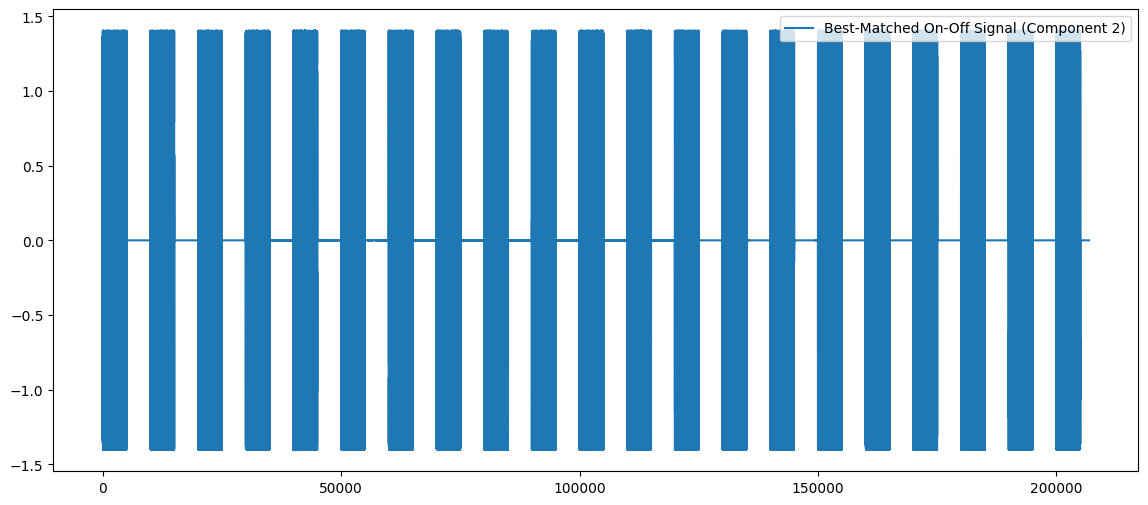

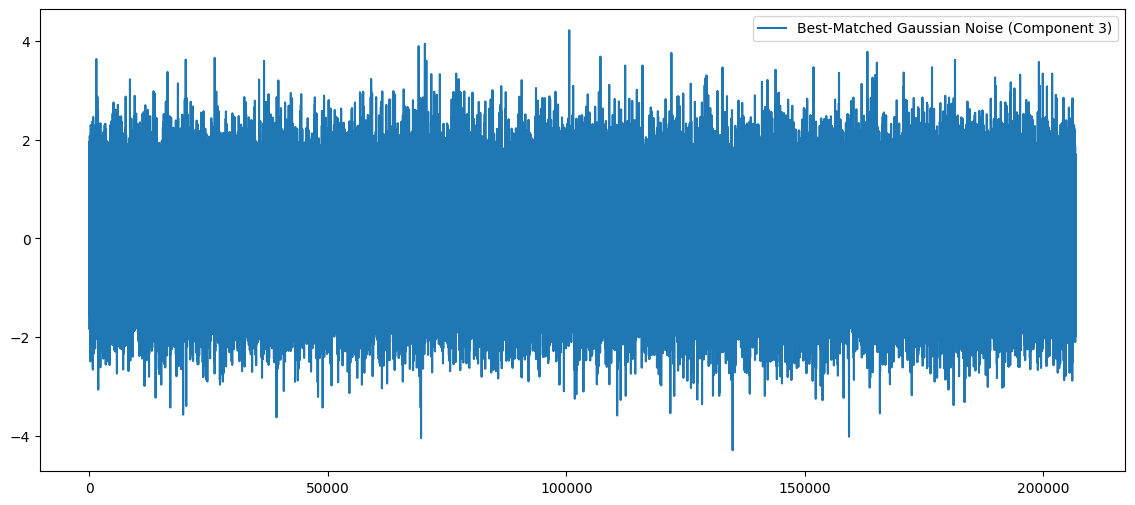

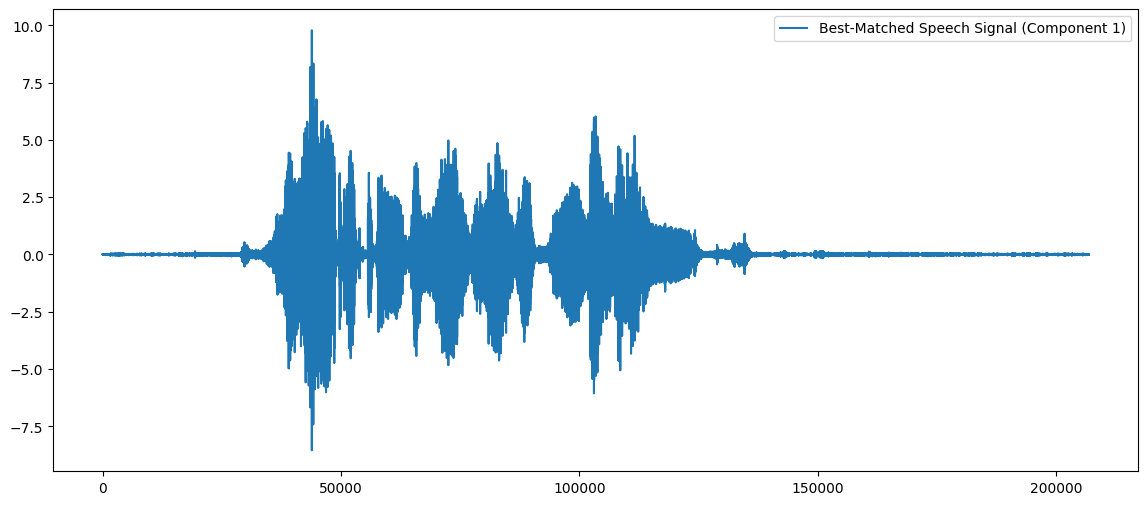

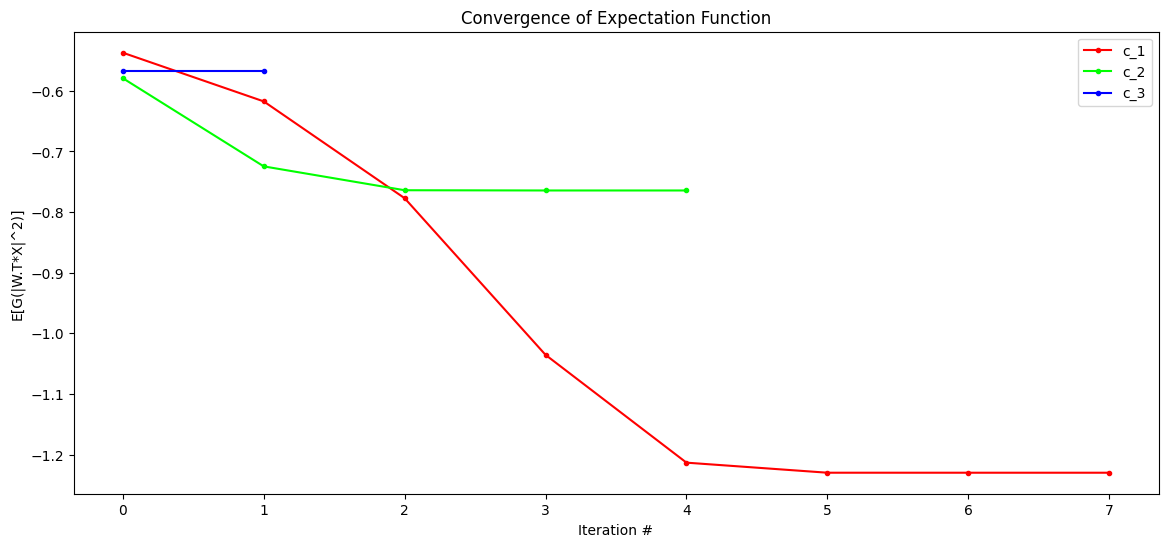

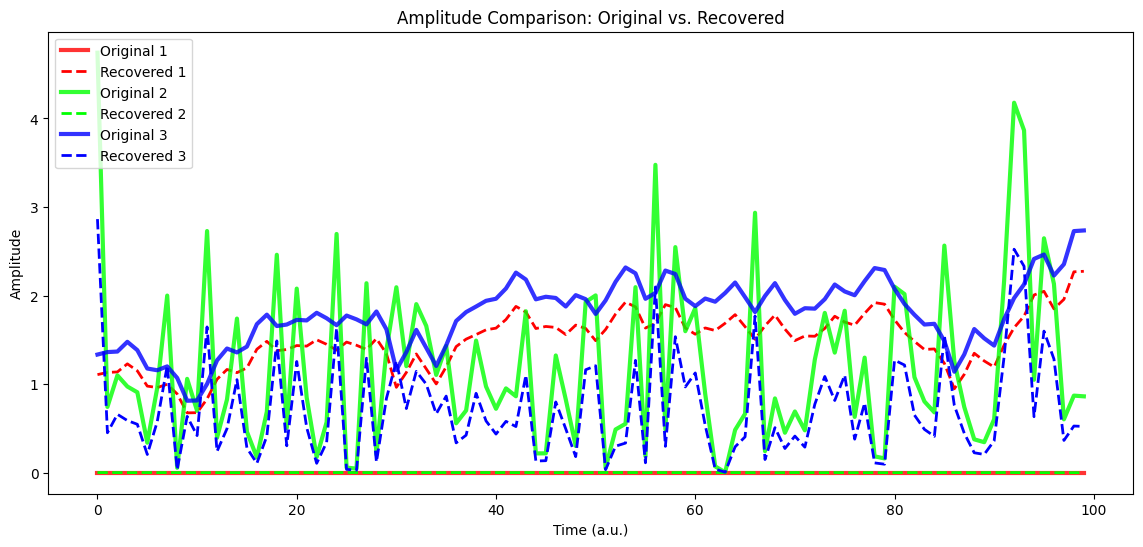

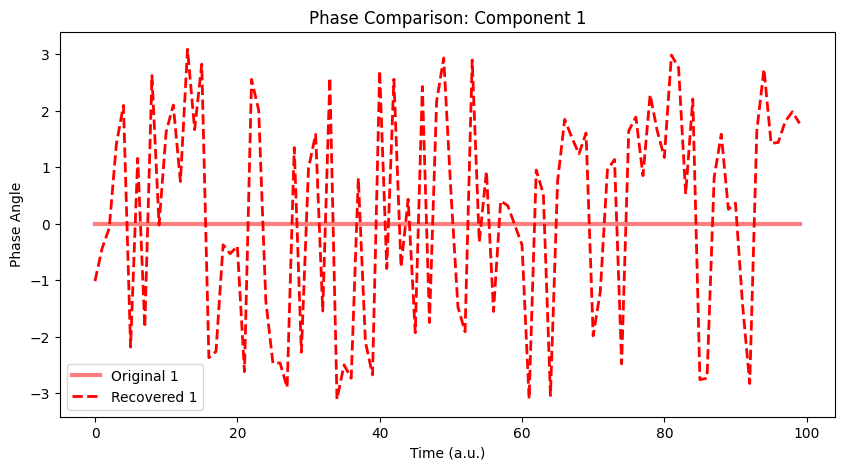

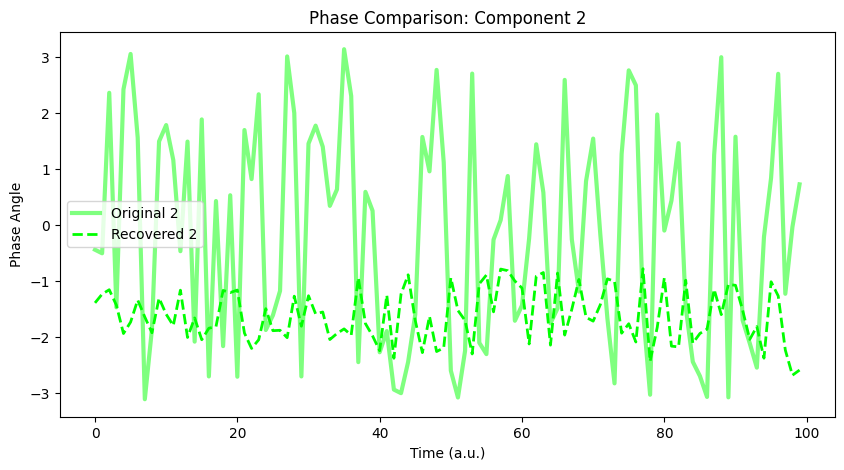

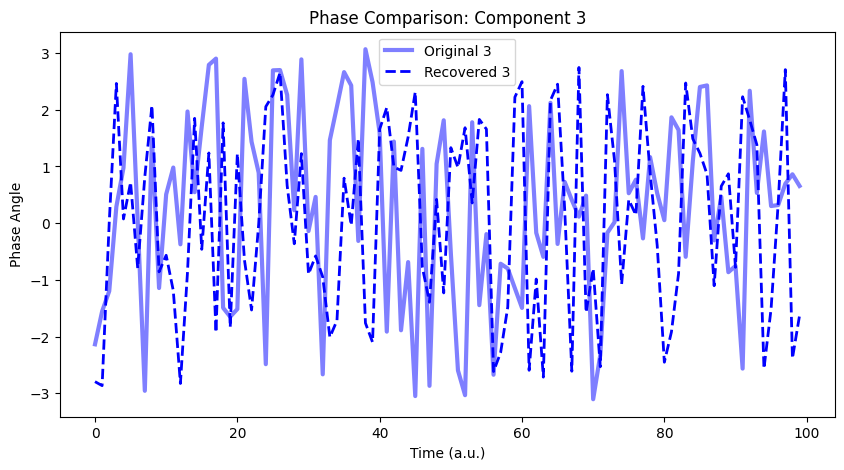

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from scipy.io import wavfile
from numpy.linalg import inv
from numpy.random import rand

plt.ion()

# Load a Speech Signal and Convert to Complex
fs, speech_signal = wavfile.read('Dev1.wav')
m = len(speech_signal)

# Compute standard deviation of the real speech signal
std_real = np.std(speech_signal)
# print(f"Standard deviation of real speech signal: {std_real:.4f}")

# Convert speech to analytic (complex) signal using Hilbert Transform
speech_complex = hilbert(speech_signal)

# Compute standard deviation of the complex speech signal
std_complex = np.std(speech_complex)
# print(f"Standard deviation of complex speech signal: {std_complex:.4f}")

# Create an On-Off Signal
block_size = 5000
on_off_signal = np.zeros(m)
for i in range(0, m, 2 * block_size):
    on_off_signal[i:i + block_size] = 1

# Gaussian Noise
noise_std=std_real/2
# print("noise std is : ",noise_std)
#or std=0.0333
gaussian_noise = np.random.normal(0,noise_std, m)
plt.figure(figsize=(10, 4))
# plt.plot(gaussian_noise, label="Raw Gaussian Noise")
# plt.legend()
# plt.show()

# Stack all signals together
S = np.vstack([on_off_signal, gaussian_noise, speech_complex])

# Convert to complex form using random phase shifts
n = S.shape[0]
f = np.random.uniform(-2*np.pi, 2*np.pi, size=(n, m))
S = S * (np.cos(f) + 1j * np.sin(f))

# Standardize the signals
# S = inv(np.diag(S.std(axis=1))).dot(S)
S /= np.abs(S).std(axis=1, keepdims=True)

# print("Min:", np.min(gaussian_noise), "Max:", np.max(gaussian_noise))
print("Noise Standardized Min:", np.min(S[1, :]), "Max:", np.max(S[1, :]))
print("Speech Standardized Min:", np.min(S[2, :]), "Max:", np.max(S[2, :]))

# Plot the Source Signals
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(on_off_signal, drawstyle='steps-post', label="ON-OFF Signal")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(np.real(S[1, :]), label="Gaussian Noise")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(np.real(S[2, :]), label="Speech Signal (Real Part)")
plt.legend()
plt.suptitle("Source Signals (Original)")
plt.show()

# Mixing using a complex mixing matrix
A = rand(n, n) + 1j * rand(n, n)
X = A.dot(S)

# Plot the Mixed Signals
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(3, 1, i+1)
    plt.plot(np.real(X[i, :]), label=f"Mixed Signal {i+1}")
    plt.legend()
plt.suptitle("Mixed Signals (After Applying Complex Mixing)")
plt.show()

# Apply Complex FastICA
alg = 'deflation'
K, W, Shat, EG = complex_FastICA(X, max_iter=40, algorithm=alg, n_components=n)

# Compute Signal-to-Interference Ratio (SIR)
absKAHW = np.abs((K.dot(A)).conj().T.dot(W))
maximum = absKAHW.max(0)
SSE = ((absKAHW**2).sum(0) - maximum**2 + (1 - maximum)**2).sum()
SIR = 10 * np.log10(((absKAHW / maximum).sum(0) - 1).mean())

print("\nSSE: %.4f" % SSE)
print("\nSIR: %.4f" % SIR)

variances = [np.var(np.real(Shat[i, :])) for i in range(n)]
print("Variances of separated components:", variances)

# Plot the Separated Signals
plt.figure(figsize=(12, 8))
for i in range(n):
    plt.subplot(3, 1, i+1)
    plt.plot(np.real(Shat[i, :]), label=f"Separated Signal {i+1}")
    plt.legend()
plt.suptitle("Separated Signals (After Complex FastICA)")
plt.show()

# Automatically identify all components using correlation
correlation_matrix = np.corrcoef(np.real(Shat), rowvar=True)  # Compute correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Compute correlations with the original signals
#this was on_off_signal, gaussian_noise, speech_complex instead of elements of S matrix. S matrix is standardized
correlations_on_off = [np.corrcoef(S[0], np.real(Shat[i, :]))[0,1] for i in range(n)]
correlations_noise = [np.corrcoef(S[1], np.real(Shat[i, :]))[0,1] for i in range(n)]
correlations_speech = [np.corrcoef(np.real(S[2]), np.real(Shat[i, :]))[0,1] for i in range(n)]

# Identify the best matching components
best_on_off = np.argmax(np.abs(correlations_on_off))
best_noise = np.argmax(np.abs(correlations_noise))
best_speech = np.argmax(np.abs(correlations_speech))

print("\nCorrelations with On-Off Signal:", correlations_on_off)
print("\nCorrelations with Gaussian Noise:", correlations_noise)
print("\nCorrelations with Speech Signal:", correlations_speech)

print(f"\nBest matching component for On-Off signal: Component {best_on_off+1} (Correlation: {correlations_on_off[best_on_off]:.4f})")
print(f"Best matching component for Gaussian Noise: Component {best_noise+1} (Correlation: {correlations_noise[best_noise]:.4f})")
print(f"Best matching component for Speech Signal: Component {best_speech+1} (Correlation: {correlations_speech[best_speech]:.4f})")

# Plot Best-Matched Separated Signals
plt.figure(figsize=(14, 6))
plt.plot(Shat[best_on_off, :], label=f"Best-Matched On-Off Signal (Component {best_on_off+1})")
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(Shat[best_noise, :], label=f"Best-Matched Gaussian Noise (Component {best_noise+1})")
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(Shat[best_speech, :], label=f"Best-Matched Speech Signal (Component {best_speech+1})")
plt.legend()
plt.show()

# Retain previous FastICA visualization plots
span = 100
start = np.random.randint(m - span)

colors = ['#FF0000', '#00FF00', '#0000FF']  # Red, Green, Blue

# **Convergence Plot**
fig1 = plt.figure(figsize=(14, 6))
ax1 = fig1.add_subplot(111)
for j in range(n):
    ax1.plot(np.ma.masked_invalid(EG[j]), '.-', color=colors[j], label=f'c_{j+1}')
ax1.set_ylabel('E[G(|W.T*X|^2)]')
ax1.set_xlabel('Iteration #')
ax1.set_title('Convergence of Expectation Function')
plt.legend(loc='best')
plt.show()

# **Amplitude Plot (Original vs. Recovered)**
fig2 = plt.figure(figsize=(14, 6))
ax2 = fig2.add_subplot(111)
for j in range(n):
    ax2.plot(np.abs(S[j, start:start+span]).T, lw=3, alpha=0.8, color=colors[j], label=f'Original {j+1}')
    ax2.plot(np.abs(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (a.u.)')
ax2.set_title('Amplitude Comparison: Original vs. Recovered')
plt.legend(loc='best', fontsize=10)
plt.show()


# **Phase Angle Plot (Original vs. Recovered)**
# fig3 = plt.figure(figsize=(14, 6))
# ax3 = fig3.add_subplot(111)
# for j in range(n):
#     ax3.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
#     ax3.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')
# ax3.set_ylabel('Angle')
# ax3.set_xlabel('Time (a.u.)')
# ax3.set_title('Phase Comparison: Original vs. Recovered')
# plt.legend(loc='best', fontsize=10)
# plt.show()


# **Phase Angle Plots (Separate for Each Component)**
for j in range(n):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)

    ax.plot(np.angle(S[j, start:start+span]).T, lw=3, alpha=0.5, color=colors[j], label=f'Original {j+1}')
    ax.plot(np.angle(Shat[j, start:start+span]).T, '--', lw=2, color=colors[j], label=f'Recovered {j+1}')

    ax.set_ylabel('Phase Angle')
    ax.set_xlabel('Time (a.u.)')
    ax.set_title(f'Phase Comparison: Component {j+1}')
    plt.legend(loc='best', fontsize=10)

    plt.show()

